<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: Predicting Sepsis

# Introduction to Project

## Problem Statement:
To identify whether a person has sepsis based on early physiological factors provided such as vital signs (pulse oximetry, systolic/ diastolic blood pressure), lab values and demographics provided

The goal of the analysis is the early detection of sepsis using physiological data.

The early prediction of sepsis is potentially life-saving, and we aim to predict sepsis n hours before the clinical prediction.

Late prediction of sepsis is potentially life-threatening, and also consumes heavy hospital resources.

By predicting sepsis in non-sepsis patients or predicting sepsis very early in sepsis patients consumes limited resources and we can assume the risk of prediction to be minimal.

## Libraries

In [1]:
#Run this cell if first time installing pycaret
#!pip install --pre pycaret

In [1]:
# importing necessary libraries
import os
import math
import pycaret
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
from pycaret.classification import *

# Loading the Datasets

In [14]:
# loading the dataset from csv
path = 'C:/Users/gohch/Documents/GA/Capstone/'
df_full = pd.read_csv(path+ 'Dataset/Dataset.csv', index_col = [0])
df = df_full


In [190]:
df_full.to_pickle('Dataset.pickle')

In [15]:
df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [16]:
df.dtypes

Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp                float64
EtCO2               float64
BaseExcess          float64
HCO3                float64
FiO2                float64
pH                  float64
PaCO2               float64
SaO2                float64
AST                 float64
BUN                 float64
Alkalinephos        float64
Calcium             float64
Chloride            float64
Creatinine          float64
Bilirubin_direct    float64
Glucose             float64
Lactate             float64
Magnesium           float64
Phosphate           float64
Potassium           float64
Bilirubin_total     float64
TroponinI           float64
Hct                 float64
Hgb                 float64
PTT                 float64
WBC                 float64
Fibrinogen          float64
Platelets           float64
Age                 

Features

- 8 Vital Signs: Heart Rate, Temperature , Blood Pressure, Respiratory rate

- 26 Laboratory Values : Platelet Count, Glucose , Calcium etc ...

- 6 Demographics: Age, Gender, Time in ICU , Hospital Admit time

- 1 Target Label: 0 (Non-sepsis) and 1 (Sepsis)

Between `Hours` and `ICULOS` (ICU Length of stay), choose to drop `ICULOS`

All the values in this dataset are numerical (no string). We change `Patient_ID` to categorical variable.

In [17]:
#df['Patient_ID'] = df['Patient_ID'].astype('category')

In [18]:
#df_['Gender'] = df['Gender'].astype('category')

In [19]:
df_full['SepsisLabel'].value_counts()

0    1524294
1      27916
Name: SepsisLabel, dtype: int64

In [20]:
percent = 27916/len(df_full)
print(f'There are {100*round(percent,4)}% counts of SepsisLabel = 1 in the whole dataset.')

There are 1.7999999999999998% counts of SepsisLabel = 1 in the whole dataset.


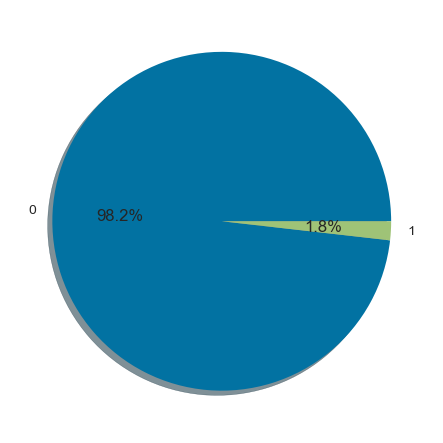

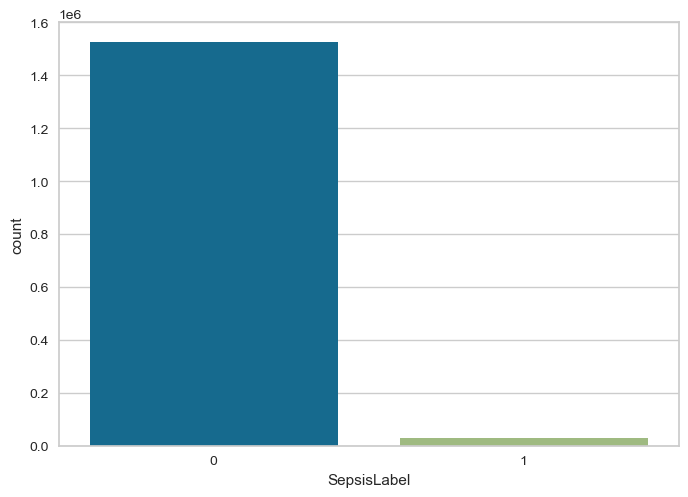

In [21]:
plt.pie(df_full['SepsisLabel'].value_counts(), labels=['0','1'], autopct='%1.1f%%', shadow=True)
plt.show()
sns.countplot(df_full['SepsisLabel'], label="Count")
plt.show()

In [22]:
len(df_full['Patient_ID'].unique())

40336

### Looking at unique patients

There are 40336 unique patients in this dataset.

In [23]:
grouped_by_patient = df_full.groupby('Patient_ID')
grouped_by_patient.sum().head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
Patient_ID,,,,,,,,,,,,,,,,,,,,,
1,1431,4977.0,4025.0,367.78,5326.0,3665.00,0.0,1241.0,0.0,145.0,...,20.4,0.0,655.0,4489.56,0,0.0,0.0,-1.62,1485,0
2,253,1341.0,2134.0,216.99,2049.0,1467.50,661.0,270.5,0.0,0.0,...,11.0,0.0,158.0,1745.93,0,0.0,23.0,-2267.80,276,0
3,1128,3582.5,4199.0,601.75,6301.5,3647.16,2284.5,1153.5,0.0,13.0,...,27.0,0.0,1439.0,2199.36,0,48.0,0.0,-57394.08,1176,0
4,406,2766.0,2651.5,218.73,2938.5,1745.83,720.0,491.0,0.0,0.0,...,7.6,0.0,364.0,1905.59,0,0.0,29.0,-254.33,435,0
5,1128,1774.0,2047.5,332.93,3186.5,1480.50,0.0,346.5,0.0,0.0,...,20.8,0.0,837.0,1348.32,48,48.0,0.0,-2.40,1224,0


In [24]:
# Create a list of patient IDs that belong to sepsis and nosepsis
temp = pd.DataFrame(grouped_by_patient.sum().SepsisLabel).reset_index()
sepsis_ids = temp[temp['SepsisLabel']> 0]['Patient_ID']
list_sepsis = list(sepsis_ids)
nosepsis_ids = temp[temp['SepsisLabel']== 0]['Patient_ID']
list_nosepsis = list(nosepsis_ids)

In [80]:
#list_sepsis = []
#list_nosepsis = []
#for x,y in enumerate(grouped_by_patient['SepsisLabel'].sum() > 0):
#    if y:
#        list_sepsis.append(x)
#    else:
#        list_nosepsis.append(x)
        
#list comprehension method to test out:
#list_sepsis = [x if y for x,y in enumerate(grouped_by_patient['SepsisLabel'].sum() > 0)]
#list_nosepsis = [x if !y for x,y in enumerate(grouped_by_patient['SepsisLabel'].sum() > 0)]

In [121]:
#sepsis_pid = np.array(grouped_by_patient[grouped_by_patient['SepsisLabel'].sum() > 0]['Patient_ID'])
#why does this not work anymore

In [25]:
percent = len(list_sepsis)/len(df_full['Patient_ID'].unique())
print(f'There are {100*round(percent,4)}% unique patients with sepsis onset in the whole dataset.')

There are 7.2700000000000005% unique patients with sepsis onset in the whole dataset.


In [26]:
#no_sepsis_pid = np.array(grouped_by_patient[grouped_by_patient['SepsisLabel'] == 0]['Patient_ID'])
#list_no_sepsis = list(no_sepsis_pid)

There are 2932 unique patients with sepsis and 37404 patients without onset of sepsis. That is 7.27% of the all unique patients in the data. The dataset is highly unbalanced.

In [27]:
#Filter sub df for patients who have sepsis
df_sepsis = df_full[df_full['Patient_ID'].isin(list_sepsis)]

In [28]:
df_sepsis.shape

(172410, 43)

In [29]:
#Filter sub df for patients who do not have sepsis
df_no_sepsis = df_full[df_full['Patient_ID'].isin(list_nosepsis)]

In [30]:
df_no_sepsis.shape

(1379800, 43)

In [31]:
df_full.shape[0] == df_sepsis.shape[0] + df_no_sepsis.shape[0]


True

In [32]:
df_sepsis.to_csv('df_sepsis.csv', index = False)
df_no_sepsis.to_csv('df_no_sepsis.csv', index = False)

# Number of hours a patient spends in Hospital

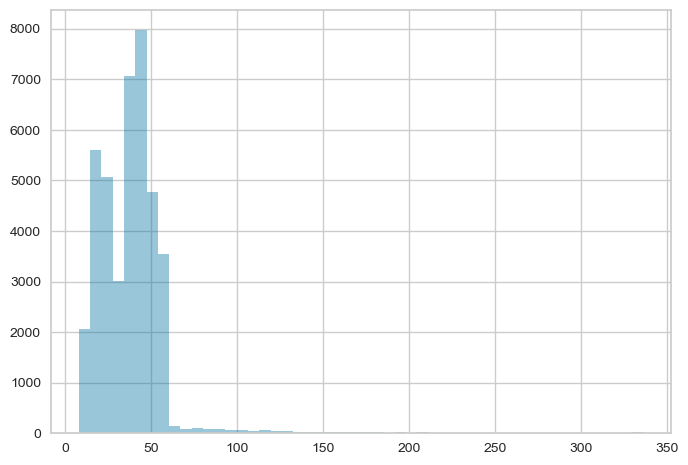

In [33]:
agg_patient_time = np.array(df_full.groupby(['Patient_ID'])['SepsisLabel'].count())
sns.distplot(agg_patient_time, kde=False);

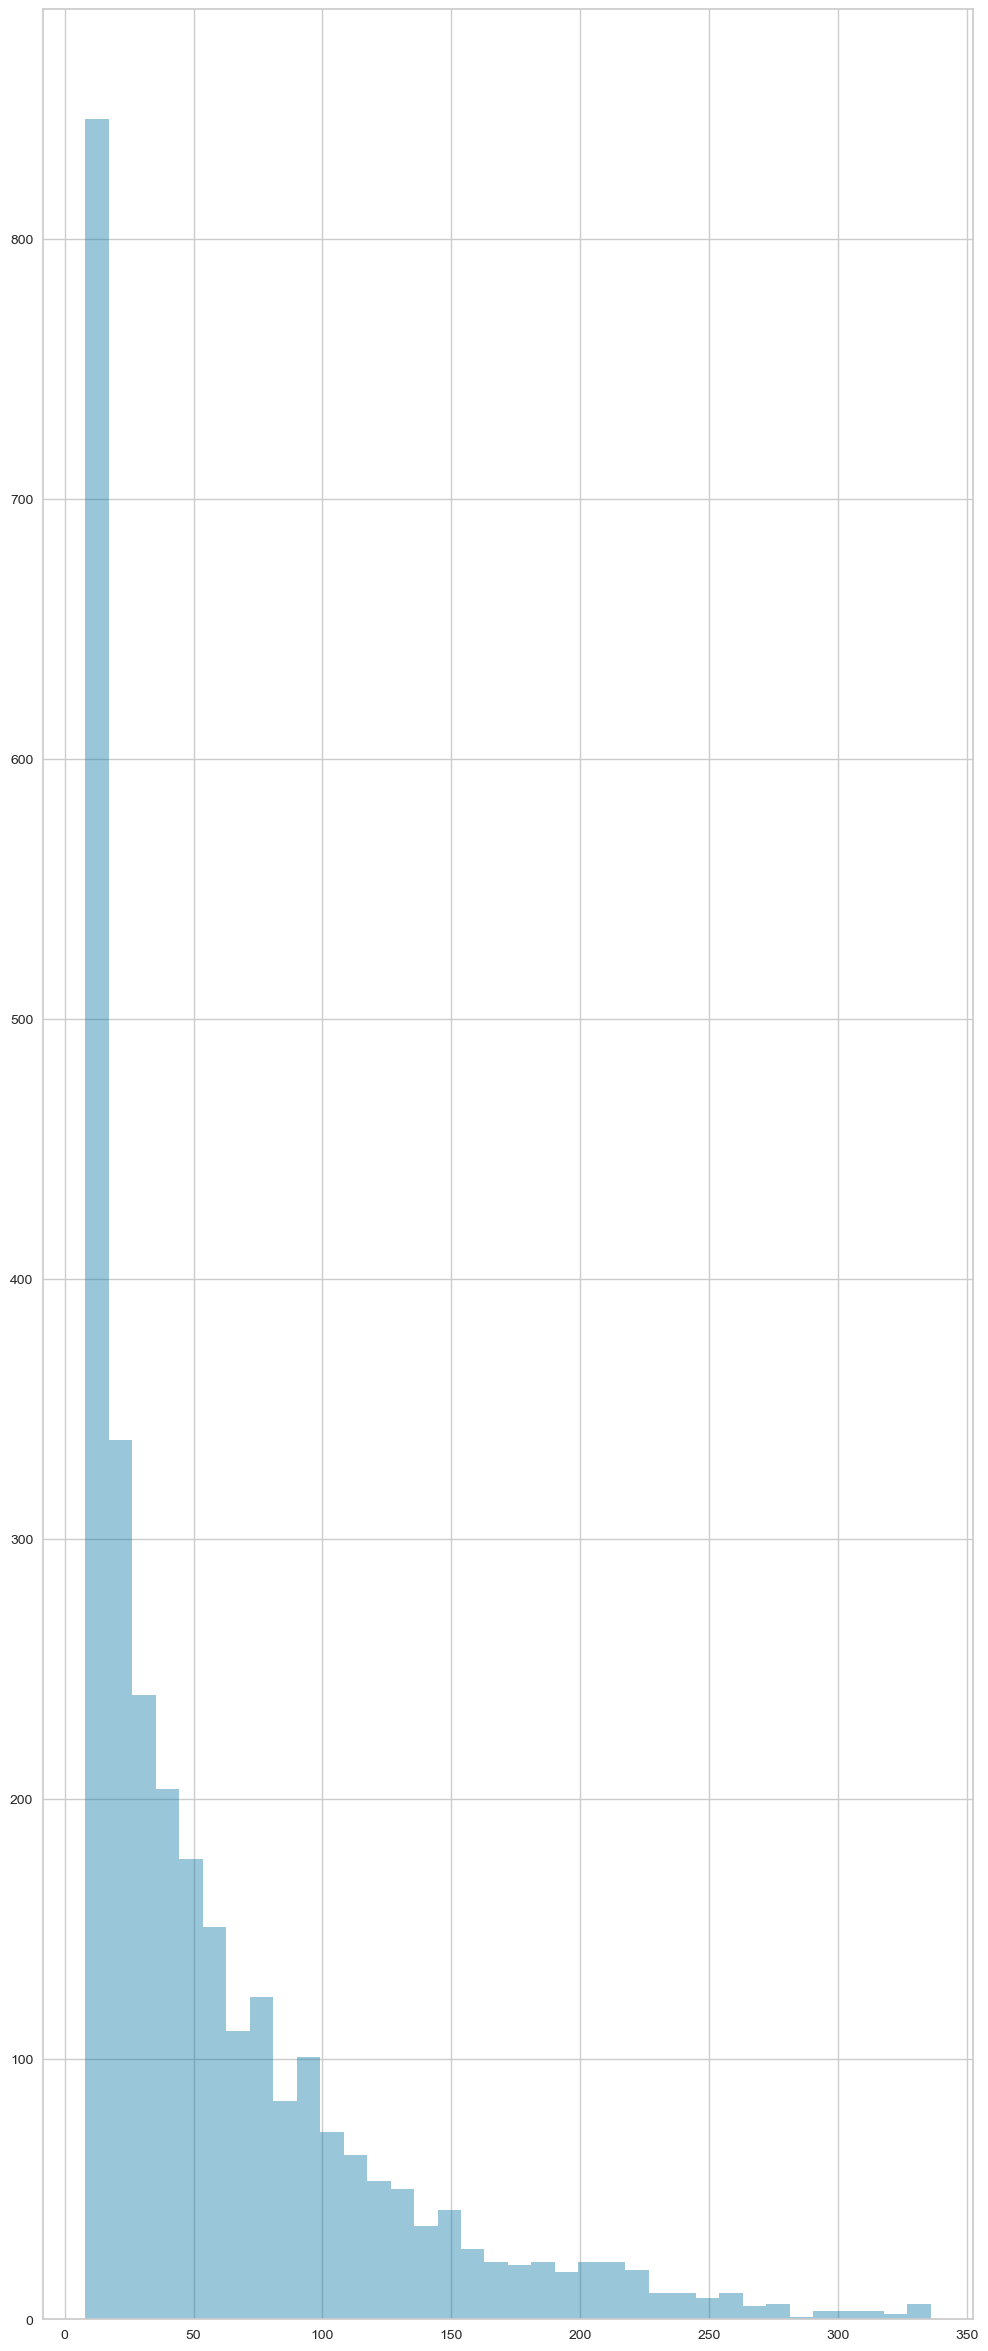

In [138]:
agg_patient_time_sepsis = np.array(df_sepsis.groupby(['Patient_ID'])['SepsisLabel'].count())

sns.distplot(agg_patient_time_sepsis, kde=False);

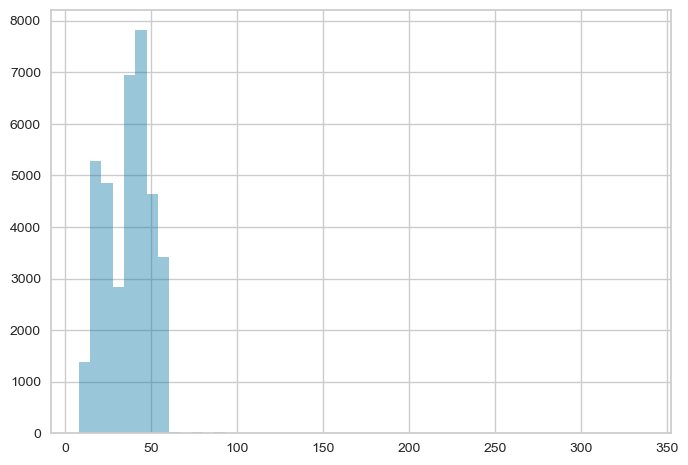

In [34]:
agg_patient_time_nosepsis = np.array(df_no_sepsis.groupby(['Patient_ID'])['SepsisLabel'].count())

sns.distplot(agg_patient_time_nosepsis, kde=False);

Patients with onset of sepsis have longer stay in the hospital, while all patients without onset of sepsis are discharged within 60 hours of admission to the hospital. This could be because patients with sepsis have serious conditions that might need longer hospitalisation to treat and monitor, instead of an indication that patients with long stay have a higher chance of sepsis onset. We would need to observe the time at which a patient contracts sepsis for this.

In [36]:
df_sepsis

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,85.57,0,1.0,0.0,-0.03,1,0,465
1,1,58.0,97.0,NaN,95.0,53.00,NaN,15.0,NaN,NaN,...,NaN,NaN,85.57,0,1.0,0.0,-0.03,2,0,465
2,2,59.0,96.0,NaN,112.0,62.00,NaN,23.0,NaN,NaN,...,NaN,NaN,85.57,0,1.0,0.0,-0.03,3,0,465
3,3,56.0,95.0,NaN,110.0,63.33,NaN,21.0,NaN,NaN,...,NaN,NaN,85.57,0,1.0,0.0,-0.03,4,0,465
4,4,70.0,98.0,36.44,118.0,66.00,NaN,16.0,NaN,NaN,...,NaN,NaN,85.57,0,1.0,0.0,-0.03,5,0,465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,15,116.0,98.0,NaN,NaN,NaN,NaN,20.0,NaN,NaN,...,NaN,NaN,54.40,0,NaN,NaN,-0.01,16,0,12701
16,16,99.0,97.0,NaN,126.0,84.00,NaN,17.0,NaN,NaN,...,NaN,NaN,54.40,0,NaN,NaN,-0.01,17,0,12701
17,17,97.0,97.0,NaN,121.0,77.00,NaN,19.0,NaN,NaN,...,NaN,NaN,54.40,0,NaN,NaN,-0.01,18,0,12701
18,18,100.0,97.0,NaN,104.0,66.67,NaN,15.0,NaN,NaN,...,NaN,NaN,54.40,0,NaN,NaN,-0.01,19,0,12701


In [140]:
df_sepsis['Hour'][::-1].iloc[0] #This gives the total length of hospital stay for the sepsis patient

9

# Time of sepsis onset for sepsis patients

In [52]:
pid_list =[]
sepsis_time_hr = []
sepsis_time_iculos = []
tot_time = []

for pid in list_sepsis:
    temp = df_sepsis[df_sepsis['Patient_ID'] == pid]
    pid_list.append(pid)
    sepsis_time_hr.append(temp[temp['SepsisLabel'] == 1].head(1).iloc[0].Hour)
    sepsis_time_iculos.append(temp[temp['SepsisLabel'] == 1].head(1).iloc[0].ICULOS)
    tot_time.append(temp['Hour'][::-1].iloc[0])
  

In [54]:
sepsis_onset_hr = dict(zip(pid_list,sepsis_time_hr))

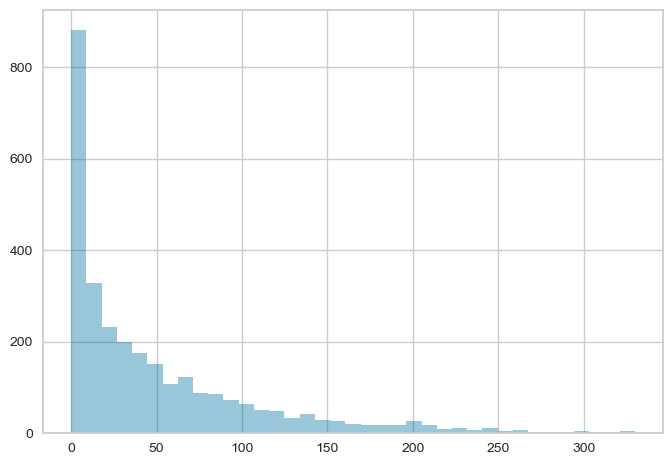

In [36]:
sns.distplot(sepsis_time_hr, kde=False);


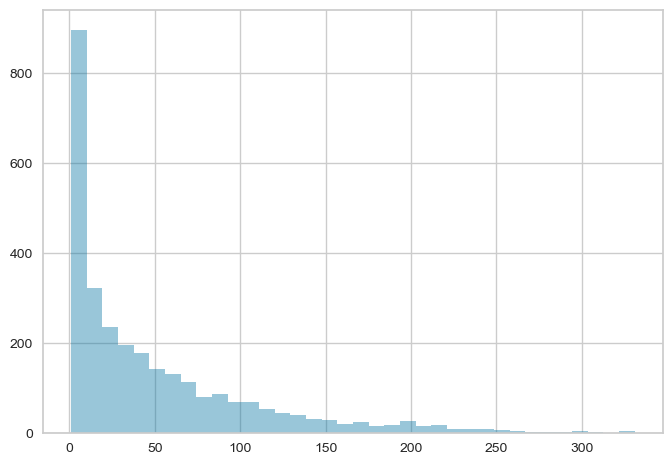

In [37]:
sns.distplot(sepsis_time_iculos, kde=False);


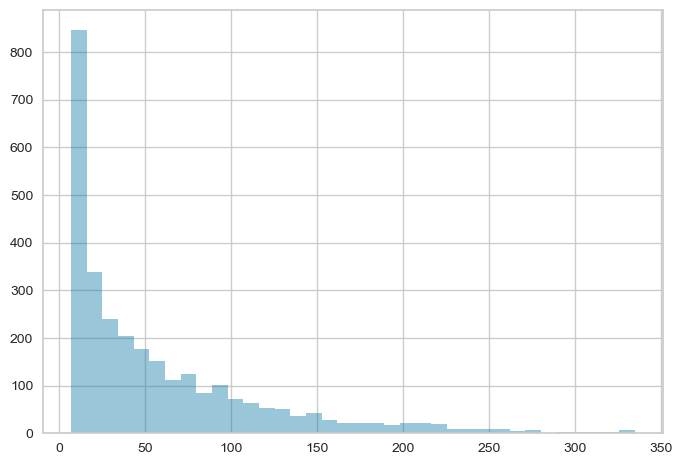

In [38]:
sns.distplot(tot_time, kde=False);

The two graphs are similar (time of sepsis onset vs. total amount of time sepsis patients stayed in hospital).

<AxesSubplot:>

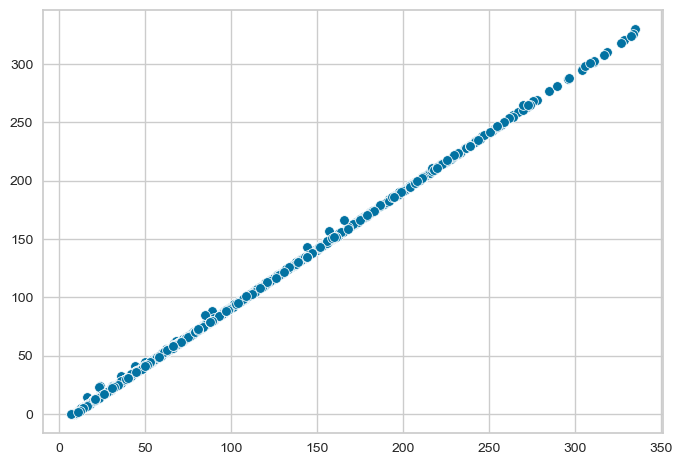

In [43]:
sns.scatterplot(tot_time, sepsis_time_hr)

<AxesSubplot:>

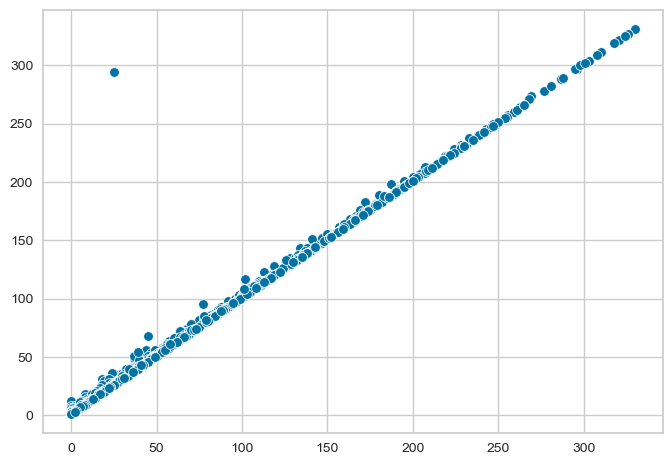

In [39]:
sns.scatterplot(sepsis_time_hr, sepsis_time_iculos)


In [44]:
testdf = pd.DataFrame(sepsis_time_hr)
testdf.columns = ['sepsis_onset']
#

In [147]:
sepsis_time[1467] #median out of 2932 patients with sepsis onset

28.0

# Windowing function

Test out the windowing function for only the sepsis patients

In [40]:
#df_full['Patient_ID'] = pd.to_numeric(df_full['Patient_ID'])
#df_subset = df_full[df_full['Patient_ID'] <= 100]
df_sepsis.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,77.0,100.0,NaN,NaN,26.5,NaN,21.00,NaN,NaN,...,NaN,NaN,59.28,1,NaN,NaN,-0.02,3,0,11093
1,1,71.5,97.5,NaN,97.0,83.5,68.0,16.50,NaN,NaN,...,NaN,158.0,59.28,1,NaN,NaN,-0.02,4,0,11093
2,2,79.0,100.0,NaN,106.0,87.0,72.0,20.75,NaN,-3.0,...,NaN,NaN,59.28,1,NaN,NaN,-0.02,5,0,11093
3,3,61.0,100.0,NaN,151.0,95.0,90.0,16.00,NaN,-3.0,...,NaN,NaN,59.28,1,NaN,NaN,-0.02,6,0,11093
4,4,49.0,100.0,NaN,145.0,92.0,84.0,20.00,NaN,-1.0,...,NaN,NaN,59.28,1,NaN,NaN,-0.02,7,0,11093


In [129]:
data_ages = df_full[['Patient_ID','Age']].drop_duplicates()
ages = dict(zip(data_ages['Patient_ID'],data_ages['Age']))

In [130]:
data_gender = df_full[['Patient_ID','Gender']].drop_duplicates()
gender = dict(zip(data_gender['Patient_ID'],data_gender['Gender']))

In [131]:
data_hospadm = df_full[['Patient_ID','HospAdmTime']].drop_duplicates()
hospadm = dict(zip(data_hospadm['Patient_ID'],data_hospadm['HospAdmTime']))

In [149]:
grouped_by_patient_sepsis = df_sepsis.groupby('Patient_ID')
grouped_by_patient_no_sepsis = df_no_sepsis.groupby('Patient_ID')

In [58]:
# Create a dictionary of all the patient_ID and the hour of onset
sepsis_onset_hr = dict(zip(pid_list,sepsis_time_hr))

55.0

In [62]:
cols_vital = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp']
cols_lab = ['BUN', 'Calcium', 'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 
            'Potassium', 'Hct', 'Hgb', 'WBC', 'Platelets']

cols_dummify = ['EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'Alkalinephos', 'Chloride',
                'Bilirubin_direct', 'Lactate', 'Bilirubin_total', 'Troponinl','PTT', 'Fibrinogen']
               
cols_demographic = ['Age', 'Gender', 'HospAdmTime']

cols_to_drop = ['Unit1' , 'Unit2']

In [150]:
win_len = 3
pred_len = 1
window_list = []
count = 0

for patient, group in grouped_by_patient_sepsis:
    count +=1 
    print(count, " : patient ",patient)
    
    x = int(sepsis_onset_hr[patient])
    
    temp_data = group.iloc[x-win_len : x] #x-win_len+pred_len] #check this
    
    temp_val_vital = temp_data[cols_vital].mean()
    temp_val_lab = temp_data[cols_lab].mean()
    
    temp_val = pd.concat([temp_val_vital, temp_val_lab],axis=0)
    testdf = pd.DataFrame(temp_val).T
    
    testdf['Patient'] = patient
    testdf['SepsisOnsetHour'] = x
    testdf['SepsisLabel'] = 1
    testdf['Age'] = ages[patient]
    testdf['Gender'] = gender[patient]
    testdf['HospAdmTime'] = hospadm[patient]
    
    window_list.append(testdf)

df_modelling_sepsis = pd.concat(window_list).reset_index(drop=True)
#df_modelling_sepsis

1  : patient  9
2  : patient  11
3  : patient  15
4  : patient  18
5  : patient  22
6  : patient  28
7  : patient  34
8  : patient  42
9  : patient  53
10  : patient  56
11  : patient  58
12  : patient  63
13  : patient  64
14  : patient  78
15  : patient  141
16  : patient  161
17  : patient  171
18  : patient  178
19  : patient  185
20  : patient  188
21  : patient  203
22  : patient  206
23  : patient  211
24  : patient  226
25  : patient  260
26  : patient  265
27  : patient  272
28  : patient  283
29  : patient  286
30  : patient  311
31  : patient  324
32  : patient  346
33  : patient  354
34  : patient  357
35  : patient  359
36  : patient  371
37  : patient  373
38  : patient  376
39  : patient  379
40  : patient  384
41  : patient  401
42  : patient  403
43  : patient  466
44  : patient  468
45  : patient  483
46  : patient  524
47  : patient  541
48  : patient  545
49  : patient  559
50  : patient  574
51  : patient  584
52  : patient  587
53  : patient  601
54  : patient  61

503  : patient  5637
504  : patient  5642
505  : patient  5644
506  : patient  5651
507  : patient  5676
508  : patient  5677
509  : patient  5688
510  : patient  5691
511  : patient  5693
512  : patient  5702
513  : patient  5710
514  : patient  5714
515  : patient  5719
516  : patient  5728
517  : patient  5748
518  : patient  5751
519  : patient  5755
520  : patient  5765
521  : patient  5772
522  : patient  5810
523  : patient  5841
524  : patient  5876
525  : patient  5885
526  : patient  5888
527  : patient  5906
528  : patient  5925
529  : patient  5932
530  : patient  5935
531  : patient  5937
532  : patient  5943
533  : patient  5950
534  : patient  5955
535  : patient  5981
536  : patient  5987
537  : patient  5998
538  : patient  6022
539  : patient  6041
540  : patient  6044
541  : patient  6046
542  : patient  6051
543  : patient  6072
544  : patient  6094
545  : patient  6101
546  : patient  6133
547  : patient  6136
548  : patient  6140
549  : patient  6158
550  : patien

931  : patient  10821
932  : patient  10829
933  : patient  10855
934  : patient  10876
935  : patient  10879
936  : patient  10880
937  : patient  10888
938  : patient  10924
939  : patient  10936
940  : patient  10948
941  : patient  10954
942  : patient  10957
943  : patient  10966
944  : patient  10974
945  : patient  10976
946  : patient  10983
947  : patient  10984
948  : patient  10992
949  : patient  10997
950  : patient  10998
951  : patient  11010
952  : patient  11056
953  : patient  11090
954  : patient  11093
955  : patient  11094
956  : patient  11105
957  : patient  11120
958  : patient  11132
959  : patient  11144
960  : patient  11156
961  : patient  11157
962  : patient  11173
963  : patient  11181
964  : patient  11187
965  : patient  11200
966  : patient  11215
967  : patient  11251
968  : patient  11272
969  : patient  11273
970  : patient  11290
971  : patient  11292
972  : patient  11294
973  : patient  11297
974  : patient  11317
975  : patient  11319
976  : pat

1386  : patient  15821
1387  : patient  15836
1388  : patient  15853
1389  : patient  15885
1390  : patient  15889
1391  : patient  15892
1392  : patient  15893
1393  : patient  15911
1394  : patient  15941
1395  : patient  15946
1396  : patient  15962
1397  : patient  15967
1398  : patient  15971
1399  : patient  15981
1400  : patient  15988
1401  : patient  15993
1402  : patient  16018
1403  : patient  16033
1404  : patient  16038
1405  : patient  16051
1406  : patient  16056
1407  : patient  16057
1408  : patient  16060
1409  : patient  16088
1410  : patient  16099
1411  : patient  16101
1412  : patient  16114
1413  : patient  16137
1414  : patient  16161
1415  : patient  16185
1416  : patient  16209
1417  : patient  16220
1418  : patient  16231
1419  : patient  16249
1420  : patient  16256
1421  : patient  16257
1422  : patient  16276
1423  : patient  16281
1424  : patient  16289
1425  : patient  16290
1426  : patient  16301
1427  : patient  16307
1428  : patient  16323
1429  : pat

1778  : patient  20524
1779  : patient  20526
1780  : patient  20538
1781  : patient  20553
1782  : patient  20554
1783  : patient  20563
1784  : patient  20565
1785  : patient  20575
1786  : patient  20585
1787  : patient  20593
1788  : patient  20601
1789  : patient  20637
1790  : patient  20643
1791  : patient  100013
1792  : patient  100016
1793  : patient  100047
1794  : patient  100049
1795  : patient  100055
1796  : patient  100068
1797  : patient  100072
1798  : patient  100073
1799  : patient  100088
1800  : patient  100100
1801  : patient  100104
1802  : patient  100111
1803  : patient  100125
1804  : patient  100162
1805  : patient  100217
1806  : patient  100218
1807  : patient  100232
1808  : patient  100275
1809  : patient  100312
1810  : patient  100333
1811  : patient  100334
1812  : patient  100356
1813  : patient  100362
1814  : patient  100367
1815  : patient  100462
1816  : patient  100470
1817  : patient  100504
1818  : patient  100527
1819  : patient  100540
1820 

2169  : patient  106826
2170  : patient  106836
2171  : patient  106855
2172  : patient  106868
2173  : patient  106896
2174  : patient  106900
2175  : patient  106914
2176  : patient  106933
2177  : patient  106943
2178  : patient  106969
2179  : patient  106984
2180  : patient  107021
2181  : patient  107022
2182  : patient  107063
2183  : patient  107111
2184  : patient  107137
2185  : patient  107138
2186  : patient  107246
2187  : patient  107250
2188  : patient  107255
2189  : patient  107262
2190  : patient  107267
2191  : patient  107279
2192  : patient  107283
2193  : patient  107297
2194  : patient  107340
2195  : patient  107350
2196  : patient  107362
2197  : patient  107372
2198  : patient  107375
2199  : patient  107424
2200  : patient  107438
2201  : patient  107461
2202  : patient  107511
2203  : patient  107525
2204  : patient  107532
2205  : patient  107547
2206  : patient  107549
2207  : patient  107563
2208  : patient  107567
2209  : patient  107599
2210  : patient 

2515  : patient  113009
2516  : patient  113023
2517  : patient  113029
2518  : patient  113036
2519  : patient  113106
2520  : patient  113119
2521  : patient  113129
2522  : patient  113135
2523  : patient  113147
2524  : patient  113150
2525  : patient  113153
2526  : patient  113192
2527  : patient  113248
2528  : patient  113260
2529  : patient  113272
2530  : patient  113277
2531  : patient  113291
2532  : patient  113302
2533  : patient  113334
2534  : patient  113377
2535  : patient  113388
2536  : patient  113392
2537  : patient  113404
2538  : patient  113406
2539  : patient  113407
2540  : patient  113428
2541  : patient  113436
2542  : patient  113443
2543  : patient  113460
2544  : patient  113489
2545  : patient  113526
2546  : patient  113562
2547  : patient  113566
2548  : patient  113599
2549  : patient  113618
2550  : patient  113626
2551  : patient  113636
2552  : patient  113683
2553  : patient  113691
2554  : patient  113729
2555  : patient  113748
2556  : patient 

2910  : patient  119713
2911  : patient  119722
2912  : patient  119738
2913  : patient  119749
2914  : patient  119751
2915  : patient  119760
2916  : patient  119765
2917  : patient  119770
2918  : patient  119791
2919  : patient  119794
2920  : patient  119808
2921  : patient  119813
2922  : patient  119822
2923  : patient  119854
2924  : patient  119867
2925  : patient  119872
2926  : patient  119874
2927  : patient  119884
2928  : patient  119888
2929  : patient  119910
2930  : patient  119917
2931  : patient  119938
2932  : patient  119959


In [155]:
window_list = []
count = 0
for patient, group in grouped_by_patient_no_sepsis:
    count +=1 
    print(count, " : patient ",patient)
    
    x = 28
    
    temp_data = group.iloc[x-win_len : x] #x-win_len+pred_len] #check this
    
    temp_val_vital = temp_data[cols_vital].mean()
    temp_val_lab = temp_data[cols_lab].mean()
    
    temp_val = pd.concat([temp_val_vital, temp_val_lab],axis=0)
    testdf = pd.DataFrame(temp_val).T
    
    testdf['Patient'] = patient
    testdf['SepsisOnsetHour'] = x
    testdf['SepsisLabel'] = 0
    testdf['Age'] = ages[patient]
    testdf['Gender'] = gender[patient]
    testdf['HospAdmTime'] = hospadm[patient]
    
    window_list.append(testdf)

df_modelling_no_sepsis = pd.concat(window_list).reset_index(drop=True)

1  : patient  1
2  : patient  2
3  : patient  3
4  : patient  4
5  : patient  5
6  : patient  6
7  : patient  7
8  : patient  8
9  : patient  10
10  : patient  12
11  : patient  13
12  : patient  14
13  : patient  16
14  : patient  17
15  : patient  19
16  : patient  20
17  : patient  21
18  : patient  23
19  : patient  24
20  : patient  25
21  : patient  26
22  : patient  27
23  : patient  29
24  : patient  30
25  : patient  31
26  : patient  32
27  : patient  33
28  : patient  35
29  : patient  36
30  : patient  37
31  : patient  38
32  : patient  39
33  : patient  40
34  : patient  41
35  : patient  43
36  : patient  44
37  : patient  45
38  : patient  46
39  : patient  47
40  : patient  48
41  : patient  49
42  : patient  50
43  : patient  51
44  : patient  52
45  : patient  54
46  : patient  55
47  : patient  57
48  : patient  59
49  : patient  60
50  : patient  61
51  : patient  62
52  : patient  65
53  : patient  66
54  : patient  67
55  : patient  68
56  : patient  69
57  : pat

487  : patient  533
488  : patient  534
489  : patient  535
490  : patient  536
491  : patient  537
492  : patient  538
493  : patient  539
494  : patient  540
495  : patient  542
496  : patient  543
497  : patient  544
498  : patient  546
499  : patient  547
500  : patient  548
501  : patient  549
502  : patient  550
503  : patient  551
504  : patient  552
505  : patient  553
506  : patient  554
507  : patient  555
508  : patient  556
509  : patient  557
510  : patient  558
511  : patient  560
512  : patient  561
513  : patient  562
514  : patient  563
515  : patient  564
516  : patient  565
517  : patient  566
518  : patient  567
519  : patient  568
520  : patient  569
521  : patient  570
522  : patient  571
523  : patient  572
524  : patient  573
525  : patient  575
526  : patient  576
527  : patient  577
528  : patient  578
529  : patient  579
530  : patient  580
531  : patient  581
532  : patient  582
533  : patient  583
534  : patient  585
535  : patient  586
536  : patient  588


900  : patient  988
901  : patient  989
902  : patient  990
903  : patient  991
904  : patient  992
905  : patient  993
906  : patient  994
907  : patient  995
908  : patient  997
909  : patient  998
910  : patient  1000
911  : patient  1001
912  : patient  1002
913  : patient  1003
914  : patient  1004
915  : patient  1005
916  : patient  1006
917  : patient  1007
918  : patient  1008
919  : patient  1009
920  : patient  1010
921  : patient  1011
922  : patient  1012
923  : patient  1013
924  : patient  1014
925  : patient  1015
926  : patient  1016
927  : patient  1017
928  : patient  1018
929  : patient  1019
930  : patient  1020
931  : patient  1021
932  : patient  1022
933  : patient  1023
934  : patient  1024
935  : patient  1025
936  : patient  1026
937  : patient  1027
938  : patient  1028
939  : patient  1029
940  : patient  1030
941  : patient  1031
942  : patient  1032
943  : patient  1033
944  : patient  1034
945  : patient  1035
946  : patient  1036
947  : patient  1037
94

1280  : patient  1413
1281  : patient  1414
1282  : patient  1415
1283  : patient  1416
1284  : patient  1417
1285  : patient  1418
1286  : patient  1419
1287  : patient  1420
1288  : patient  1421
1289  : patient  1422
1290  : patient  1423
1291  : patient  1424
1292  : patient  1425
1293  : patient  1426
1294  : patient  1427
1295  : patient  1428
1296  : patient  1430
1297  : patient  1431
1298  : patient  1432
1299  : patient  1434
1300  : patient  1436
1301  : patient  1437
1302  : patient  1438
1303  : patient  1442
1304  : patient  1443
1305  : patient  1444
1306  : patient  1445
1307  : patient  1447
1308  : patient  1448
1309  : patient  1449
1310  : patient  1450
1311  : patient  1451
1312  : patient  1452
1313  : patient  1453
1314  : patient  1454
1315  : patient  1455
1316  : patient  1456
1317  : patient  1457
1318  : patient  1458
1319  : patient  1459
1320  : patient  1460
1321  : patient  1462
1322  : patient  1463
1323  : patient  1464
1324  : patient  1465
1325  : pa

1674  : patient  1846
1675  : patient  1847
1676  : patient  1848
1677  : patient  1850
1678  : patient  1851
1679  : patient  1852
1680  : patient  1853
1681  : patient  1854
1682  : patient  1855
1683  : patient  1856
1684  : patient  1857
1685  : patient  1858
1686  : patient  1859
1687  : patient  1860
1688  : patient  1862
1689  : patient  1864
1690  : patient  1865
1691  : patient  1866
1692  : patient  1867
1693  : patient  1868
1694  : patient  1869
1695  : patient  1870
1696  : patient  1871
1697  : patient  1872
1698  : patient  1874
1699  : patient  1875
1700  : patient  1876
1701  : patient  1877
1702  : patient  1878
1703  : patient  1879
1704  : patient  1880
1705  : patient  1881
1706  : patient  1882
1707  : patient  1883
1708  : patient  1884
1709  : patient  1885
1710  : patient  1886
1711  : patient  1887
1712  : patient  1888
1713  : patient  1889
1714  : patient  1890
1715  : patient  1891
1716  : patient  1892
1717  : patient  1893
1718  : patient  1894
1719  : pa

2146  : patient  2358
2147  : patient  2359
2148  : patient  2361
2149  : patient  2362
2150  : patient  2363
2151  : patient  2364
2152  : patient  2365
2153  : patient  2366
2154  : patient  2367
2155  : patient  2368
2156  : patient  2369
2157  : patient  2370
2158  : patient  2371
2159  : patient  2372
2160  : patient  2373
2161  : patient  2374
2162  : patient  2375
2163  : patient  2376
2164  : patient  2377
2165  : patient  2378
2166  : patient  2379
2167  : patient  2380
2168  : patient  2381
2169  : patient  2382
2170  : patient  2383
2171  : patient  2384
2172  : patient  2385
2173  : patient  2386
2174  : patient  2387
2175  : patient  2388
2176  : patient  2389
2177  : patient  2390
2178  : patient  2391
2179  : patient  2392
2180  : patient  2393
2181  : patient  2394
2182  : patient  2395
2183  : patient  2396
2184  : patient  2397
2185  : patient  2398
2186  : patient  2400
2187  : patient  2401
2188  : patient  2402
2189  : patient  2403
2190  : patient  2405
2191  : pa

2570  : patient  2821
2571  : patient  2822
2572  : patient  2823
2573  : patient  2824
2574  : patient  2825
2575  : patient  2826
2576  : patient  2827
2577  : patient  2828
2578  : patient  2829
2579  : patient  2830
2580  : patient  2831
2581  : patient  2832
2582  : patient  2833
2583  : patient  2834
2584  : patient  2835
2585  : patient  2836
2586  : patient  2837
2587  : patient  2838
2588  : patient  2839
2589  : patient  2840
2590  : patient  2841
2591  : patient  2842
2592  : patient  2843
2593  : patient  2844
2594  : patient  2845
2595  : patient  2846
2596  : patient  2847
2597  : patient  2848
2598  : patient  2849
2599  : patient  2850
2600  : patient  2851
2601  : patient  2854
2602  : patient  2855
2603  : patient  2856
2604  : patient  2857
2605  : patient  2858
2606  : patient  2859
2607  : patient  2860
2608  : patient  2861
2609  : patient  2862
2610  : patient  2863
2611  : patient  2864
2612  : patient  2865
2613  : patient  2866
2614  : patient  2867
2615  : pa

2982  : patient  3281
2983  : patient  3282
2984  : patient  3283
2985  : patient  3284
2986  : patient  3285
2987  : patient  3286
2988  : patient  3287
2989  : patient  3288
2990  : patient  3289
2991  : patient  3290
2992  : patient  3291
2993  : patient  3292
2994  : patient  3293
2995  : patient  3294
2996  : patient  3295
2997  : patient  3296
2998  : patient  3297
2999  : patient  3298
3000  : patient  3299
3001  : patient  3300
3002  : patient  3301
3003  : patient  3302
3004  : patient  3303
3005  : patient  3304
3006  : patient  3305
3007  : patient  3306
3008  : patient  3307
3009  : patient  3309
3010  : patient  3310
3011  : patient  3311
3012  : patient  3312
3013  : patient  3313
3014  : patient  3314
3015  : patient  3315
3016  : patient  3316
3017  : patient  3317
3018  : patient  3318
3019  : patient  3319
3020  : patient  3320
3021  : patient  3322
3022  : patient  3324
3023  : patient  3326
3024  : patient  3327
3025  : patient  3328
3026  : patient  3329
3027  : pa

3391  : patient  3734
3392  : patient  3735
3393  : patient  3736
3394  : patient  3737
3395  : patient  3738
3396  : patient  3739
3397  : patient  3740
3398  : patient  3741
3399  : patient  3742
3400  : patient  3743
3401  : patient  3744
3402  : patient  3745
3403  : patient  3746
3404  : patient  3747
3405  : patient  3748
3406  : patient  3749
3407  : patient  3750
3408  : patient  3751
3409  : patient  3753
3410  : patient  3754
3411  : patient  3755
3412  : patient  3756
3413  : patient  3757
3414  : patient  3758
3415  : patient  3759
3416  : patient  3760
3417  : patient  3761
3418  : patient  3762
3419  : patient  3763
3420  : patient  3764
3421  : patient  3765
3422  : patient  3766
3423  : patient  3767
3424  : patient  3769
3425  : patient  3770
3426  : patient  3771
3427  : patient  3772
3428  : patient  3773
3429  : patient  3774
3430  : patient  3775
3431  : patient  3776
3432  : patient  3777
3433  : patient  3779
3434  : patient  3780
3435  : patient  3781
3436  : pa

3796  : patient  4170
3797  : patient  4171
3798  : patient  4172
3799  : patient  4175
3800  : patient  4176
3801  : patient  4177
3802  : patient  4178
3803  : patient  4179
3804  : patient  4180
3805  : patient  4181
3806  : patient  4182
3807  : patient  4184
3808  : patient  4185
3809  : patient  4186
3810  : patient  4187
3811  : patient  4188
3812  : patient  4189
3813  : patient  4190
3814  : patient  4191
3815  : patient  4192
3816  : patient  4193
3817  : patient  4194
3818  : patient  4195
3819  : patient  4196
3820  : patient  4198
3821  : patient  4199
3822  : patient  4201
3823  : patient  4202
3824  : patient  4203
3825  : patient  4204
3826  : patient  4205
3827  : patient  4206
3828  : patient  4207
3829  : patient  4208
3830  : patient  4210
3831  : patient  4211
3832  : patient  4212
3833  : patient  4213
3834  : patient  4214
3835  : patient  4215
3836  : patient  4216
3837  : patient  4217
3838  : patient  4218
3839  : patient  4219
3840  : patient  4220
3841  : pa

4179  : patient  4580
4180  : patient  4581
4181  : patient  4582
4182  : patient  4583
4183  : patient  4584
4184  : patient  4585
4185  : patient  4586
4186  : patient  4587
4187  : patient  4588
4188  : patient  4589
4189  : patient  4590
4190  : patient  4591
4191  : patient  4592
4192  : patient  4593
4193  : patient  4594
4194  : patient  4595
4195  : patient  4596
4196  : patient  4597
4197  : patient  4598
4198  : patient  4600
4199  : patient  4601
4200  : patient  4602
4201  : patient  4603
4202  : patient  4604
4203  : patient  4605
4204  : patient  4606
4205  : patient  4607
4206  : patient  4608
4207  : patient  4609
4208  : patient  4610
4209  : patient  4611
4210  : patient  4612
4211  : patient  4613
4212  : patient  4614
4213  : patient  4615
4214  : patient  4616
4215  : patient  4617
4216  : patient  4619
4217  : patient  4620
4218  : patient  4621
4219  : patient  4622
4220  : patient  4623
4221  : patient  4624
4222  : patient  4625
4223  : patient  4626
4224  : pa

4588  : patient  5036
4589  : patient  5039
4590  : patient  5040
4591  : patient  5041
4592  : patient  5042
4593  : patient  5043
4594  : patient  5044
4595  : patient  5045
4596  : patient  5046
4597  : patient  5047
4598  : patient  5048
4599  : patient  5049
4600  : patient  5050
4601  : patient  5051
4602  : patient  5052
4603  : patient  5054
4604  : patient  5055
4605  : patient  5056
4606  : patient  5057
4607  : patient  5058
4608  : patient  5059
4609  : patient  5060
4610  : patient  5061
4611  : patient  5062
4612  : patient  5063
4613  : patient  5064
4614  : patient  5065
4615  : patient  5066
4616  : patient  5067
4617  : patient  5068
4618  : patient  5069
4619  : patient  5070
4620  : patient  5071
4621  : patient  5072
4622  : patient  5073
4623  : patient  5074
4624  : patient  5075
4625  : patient  5076
4626  : patient  5077
4627  : patient  5078
4628  : patient  5080
4629  : patient  5081
4630  : patient  5082
4631  : patient  5083
4632  : patient  5084
4633  : pa

5021  : patient  5513
5022  : patient  5514
5023  : patient  5515
5024  : patient  5516
5025  : patient  5517
5026  : patient  5518
5027  : patient  5520
5028  : patient  5521
5029  : patient  5522
5030  : patient  5523
5031  : patient  5524
5032  : patient  5525
5033  : patient  5526
5034  : patient  5527
5035  : patient  5528
5036  : patient  5529
5037  : patient  5530
5038  : patient  5531
5039  : patient  5532
5040  : patient  5534
5041  : patient  5535
5042  : patient  5536
5043  : patient  5537
5044  : patient  5538
5045  : patient  5540
5046  : patient  5541
5047  : patient  5542
5048  : patient  5543
5049  : patient  5544
5050  : patient  5546
5051  : patient  5547
5052  : patient  5548
5053  : patient  5549
5054  : patient  5550
5055  : patient  5551
5056  : patient  5552
5057  : patient  5553
5058  : patient  5555
5059  : patient  5556
5060  : patient  5557
5061  : patient  5558
5062  : patient  5559
5063  : patient  5560
5064  : patient  5561
5065  : patient  5562
5066  : pa

5495  : patient  6033
5496  : patient  6034
5497  : patient  6035
5498  : patient  6036
5499  : patient  6037
5500  : patient  6038
5501  : patient  6039
5502  : patient  6040
5503  : patient  6042
5504  : patient  6043
5505  : patient  6045
5506  : patient  6047
5507  : patient  6048
5508  : patient  6049
5509  : patient  6050
5510  : patient  6052
5511  : patient  6053
5512  : patient  6054
5513  : patient  6055
5514  : patient  6056
5515  : patient  6057
5516  : patient  6058
5517  : patient  6059
5518  : patient  6060
5519  : patient  6061
5520  : patient  6062
5521  : patient  6063
5522  : patient  6064
5523  : patient  6065
5524  : patient  6066
5525  : patient  6067
5526  : patient  6068
5527  : patient  6069
5528  : patient  6070
5529  : patient  6071
5530  : patient  6073
5531  : patient  6074
5532  : patient  6075
5533  : patient  6076
5534  : patient  6077
5535  : patient  6078
5536  : patient  6079
5537  : patient  6080
5538  : patient  6081
5539  : patient  6082
5540  : pa

5940  : patient  6520
5941  : patient  6521
5942  : patient  6522
5943  : patient  6523
5944  : patient  6524
5945  : patient  6525
5946  : patient  6526
5947  : patient  6527
5948  : patient  6528
5949  : patient  6529
5950  : patient  6530
5951  : patient  6531
5952  : patient  6532
5953  : patient  6533
5954  : patient  6534
5955  : patient  6535
5956  : patient  6536
5957  : patient  6538
5958  : patient  6539
5959  : patient  6540
5960  : patient  6541
5961  : patient  6542
5962  : patient  6543
5963  : patient  6544
5964  : patient  6545
5965  : patient  6546
5966  : patient  6547
5967  : patient  6548
5968  : patient  6549
5969  : patient  6550
5970  : patient  6551
5971  : patient  6552
5972  : patient  6553
5973  : patient  6554
5974  : patient  6555
5975  : patient  6556
5976  : patient  6557
5977  : patient  6558
5978  : patient  6559
5979  : patient  6560
5980  : patient  6561
5981  : patient  6562
5982  : patient  6563
5983  : patient  6564
5984  : patient  6565
5985  : pa

6377  : patient  6980
6378  : patient  6981
6379  : patient  6982
6380  : patient  6983
6381  : patient  6985
6382  : patient  6986
6383  : patient  6987
6384  : patient  6988
6385  : patient  6989
6386  : patient  6990
6387  : patient  6991
6388  : patient  6992
6389  : patient  6993
6390  : patient  6994
6391  : patient  6996
6392  : patient  6997
6393  : patient  6998
6394  : patient  6999
6395  : patient  7000
6396  : patient  7002
6397  : patient  7003
6398  : patient  7004
6399  : patient  7005
6400  : patient  7006
6401  : patient  7007
6402  : patient  7008
6403  : patient  7009
6404  : patient  7010
6405  : patient  7011
6406  : patient  7012
6407  : patient  7013
6408  : patient  7014
6409  : patient  7015
6410  : patient  7016
6411  : patient  7019
6412  : patient  7020
6413  : patient  7021
6414  : patient  7022
6415  : patient  7023
6416  : patient  7024
6417  : patient  7025
6418  : patient  7026
6419  : patient  7027
6420  : patient  7028
6421  : patient  7029
6422  : pa

6799  : patient  7434
6800  : patient  7435
6801  : patient  7436
6802  : patient  7437
6803  : patient  7438
6804  : patient  7439
6805  : patient  7440
6806  : patient  7441
6807  : patient  7442
6808  : patient  7443
6809  : patient  7444
6810  : patient  7445
6811  : patient  7446
6812  : patient  7447
6813  : patient  7448
6814  : patient  7449
6815  : patient  7450
6816  : patient  7451
6817  : patient  7452
6818  : patient  7453
6819  : patient  7454
6820  : patient  7455
6821  : patient  7457
6822  : patient  7458
6823  : patient  7460
6824  : patient  7461
6825  : patient  7462
6826  : patient  7463
6827  : patient  7464
6828  : patient  7465
6829  : patient  7466
6830  : patient  7467
6831  : patient  7468
6832  : patient  7469
6833  : patient  7470
6834  : patient  7471
6835  : patient  7473
6836  : patient  7474
6837  : patient  7475
6838  : patient  7476
6839  : patient  7477
6840  : patient  7478
6841  : patient  7479
6842  : patient  7480
6843  : patient  7482
6844  : pa

7273  : patient  7945
7274  : patient  7946
7275  : patient  7947
7276  : patient  7948
7277  : patient  7949
7278  : patient  7950
7279  : patient  7951
7280  : patient  7952
7281  : patient  7953
7282  : patient  7954
7283  : patient  7955
7284  : patient  7956
7285  : patient  7957
7286  : patient  7958
7287  : patient  7959
7288  : patient  7960
7289  : patient  7961
7290  : patient  7962
7291  : patient  7964
7292  : patient  7965
7293  : patient  7967
7294  : patient  7968
7295  : patient  7969
7296  : patient  7970
7297  : patient  7971
7298  : patient  7973
7299  : patient  7974
7300  : patient  7977
7301  : patient  7978
7302  : patient  7979
7303  : patient  7981
7304  : patient  7982
7305  : patient  7983
7306  : patient  7984
7307  : patient  7985
7308  : patient  7986
7309  : patient  7988
7310  : patient  7989
7311  : patient  7990
7312  : patient  7991
7313  : patient  7992
7314  : patient  7993
7315  : patient  7994
7316  : patient  7995
7317  : patient  7996
7318  : pa

7707  : patient  8423
7708  : patient  8424
7709  : patient  8425
7710  : patient  8426
7711  : patient  8427
7712  : patient  8428
7713  : patient  8429
7714  : patient  8430
7715  : patient  8431
7716  : patient  8432
7717  : patient  8433
7718  : patient  8434
7719  : patient  8435
7720  : patient  8436
7721  : patient  8437
7722  : patient  8438
7723  : patient  8439
7724  : patient  8440
7725  : patient  8441
7726  : patient  8442
7727  : patient  8443
7728  : patient  8444
7729  : patient  8445
7730  : patient  8446
7731  : patient  8447
7732  : patient  8449
7733  : patient  8450
7734  : patient  8451
7735  : patient  8452
7736  : patient  8454
7737  : patient  8455
7738  : patient  8456
7739  : patient  8457
7740  : patient  8458
7741  : patient  8459
7742  : patient  8461
7743  : patient  8462
7744  : patient  8463
7745  : patient  8464
7746  : patient  8465
7747  : patient  8466
7748  : patient  8467
7749  : patient  8468
7750  : patient  8469
7751  : patient  8471
7752  : pa

8099  : patient  8855
8100  : patient  8856
8101  : patient  8857
8102  : patient  8858
8103  : patient  8859
8104  : patient  8860
8105  : patient  8862
8106  : patient  8863
8107  : patient  8864
8108  : patient  8865
8109  : patient  8866
8110  : patient  8868
8111  : patient  8869
8112  : patient  8870
8113  : patient  8871
8114  : patient  8872
8115  : patient  8874
8116  : patient  8875
8117  : patient  8876
8118  : patient  8877
8119  : patient  8878
8120  : patient  8879
8121  : patient  8880
8122  : patient  8881
8123  : patient  8882
8124  : patient  8883
8125  : patient  8884
8126  : patient  8885
8127  : patient  8886
8128  : patient  8887
8129  : patient  8888
8130  : patient  8889
8131  : patient  8891
8132  : patient  8892
8133  : patient  8893
8134  : patient  8894
8135  : patient  8895
8136  : patient  8896
8137  : patient  8897
8138  : patient  8898
8139  : patient  8899
8140  : patient  8900
8141  : patient  8901
8142  : patient  8902
8143  : patient  8903
8144  : pa

8539  : patient  9340
8540  : patient  9341
8541  : patient  9342
8542  : patient  9343
8543  : patient  9344
8544  : patient  9345
8545  : patient  9346
8546  : patient  9347
8547  : patient  9348
8548  : patient  9349
8549  : patient  9350
8550  : patient  9351
8551  : patient  9352
8552  : patient  9353
8553  : patient  9354
8554  : patient  9355
8555  : patient  9356
8556  : patient  9357
8557  : patient  9358
8558  : patient  9359
8559  : patient  9362
8560  : patient  9363
8561  : patient  9364
8562  : patient  9365
8563  : patient  9366
8564  : patient  9367
8565  : patient  9368
8566  : patient  9369
8567  : patient  9370
8568  : patient  9371
8569  : patient  9373
8570  : patient  9374
8571  : patient  9375
8572  : patient  9376
8573  : patient  9377
8574  : patient  9378
8575  : patient  9379
8576  : patient  9380
8577  : patient  9381
8578  : patient  9382
8579  : patient  9383
8580  : patient  9384
8581  : patient  9385
8582  : patient  9386
8583  : patient  9387
8584  : pa

8920  : patient  9758
8921  : patient  9759
8922  : patient  9760
8923  : patient  9762
8924  : patient  9763
8925  : patient  9764
8926  : patient  9765
8927  : patient  9766
8928  : patient  9767
8929  : patient  9768
8930  : patient  9769
8931  : patient  9770
8932  : patient  9771
8933  : patient  9772
8934  : patient  9773
8935  : patient  9774
8936  : patient  9775
8937  : patient  9777
8938  : patient  9778
8939  : patient  9779
8940  : patient  9780
8941  : patient  9781
8942  : patient  9782
8943  : patient  9783
8944  : patient  9784
8945  : patient  9786
8946  : patient  9787
8947  : patient  9788
8948  : patient  9789
8949  : patient  9790
8950  : patient  9791
8951  : patient  9792
8952  : patient  9793
8953  : patient  9794
8954  : patient  9795
8955  : patient  9796
8956  : patient  9797
8957  : patient  9798
8958  : patient  9799
8959  : patient  9800
8960  : patient  9801
8961  : patient  9802
8962  : patient  9803
8963  : patient  9804
8964  : patient  9805
8965  : pa

9357  : patient  10240
9358  : patient  10241
9359  : patient  10242
9360  : patient  10243
9361  : patient  10244
9362  : patient  10245
9363  : patient  10246
9364  : patient  10247
9365  : patient  10248
9366  : patient  10249
9367  : patient  10250
9368  : patient  10251
9369  : patient  10252
9370  : patient  10254
9371  : patient  10255
9372  : patient  10256
9373  : patient  10257
9374  : patient  10258
9375  : patient  10259
9376  : patient  10260
9377  : patient  10261
9378  : patient  10263
9379  : patient  10265
9380  : patient  10266
9381  : patient  10267
9382  : patient  10268
9383  : patient  10269
9384  : patient  10270
9385  : patient  10271
9386  : patient  10272
9387  : patient  10273
9388  : patient  10274
9389  : patient  10275
9390  : patient  10276
9391  : patient  10277
9392  : patient  10278
9393  : patient  10279
9394  : patient  10281
9395  : patient  10282
9396  : patient  10283
9397  : patient  10284
9398  : patient  10285
9399  : patient  10286
9400  : pat

9740  : patient  10654
9741  : patient  10655
9742  : patient  10657
9743  : patient  10658
9744  : patient  10659
9745  : patient  10660
9746  : patient  10661
9747  : patient  10662
9748  : patient  10663
9749  : patient  10666
9750  : patient  10667
9751  : patient  10668
9752  : patient  10669
9753  : patient  10670
9754  : patient  10671
9755  : patient  10672
9756  : patient  10673
9757  : patient  10674
9758  : patient  10675
9759  : patient  10676
9760  : patient  10677
9761  : patient  10678
9762  : patient  10679
9763  : patient  10680
9764  : patient  10681
9765  : patient  10683
9766  : patient  10684
9767  : patient  10685
9768  : patient  10687
9769  : patient  10688
9770  : patient  10689
9771  : patient  10690
9772  : patient  10691
9773  : patient  10692
9774  : patient  10693
9775  : patient  10694
9776  : patient  10695
9777  : patient  10696
9778  : patient  10697
9779  : patient  10698
9780  : patient  10699
9781  : patient  10701
9782  : patient  10702
9783  : pat

10138  : patient  11091
10139  : patient  11092
10140  : patient  11095
10141  : patient  11096
10142  : patient  11097
10143  : patient  11098
10144  : patient  11099
10145  : patient  11100
10146  : patient  11101
10147  : patient  11102
10148  : patient  11103
10149  : patient  11104
10150  : patient  11106
10151  : patient  11107
10152  : patient  11108
10153  : patient  11109
10154  : patient  11110
10155  : patient  11111
10156  : patient  11112
10157  : patient  11113
10158  : patient  11114
10159  : patient  11115
10160  : patient  11116
10161  : patient  11117
10162  : patient  11118
10163  : patient  11119
10164  : patient  11121
10165  : patient  11122
10166  : patient  11123
10167  : patient  11124
10168  : patient  11125
10169  : patient  11126
10170  : patient  11127
10171  : patient  11128
10172  : patient  11129
10173  : patient  11130
10174  : patient  11131
10175  : patient  11133
10176  : patient  11134
10177  : patient  11135
10178  : patient  11136
10179  : patient

10490  : patient  11477
10491  : patient  11478
10492  : patient  11479
10493  : patient  11481
10494  : patient  11482
10495  : patient  11483
10496  : patient  11484
10497  : patient  11485
10498  : patient  11486
10499  : patient  11487
10500  : patient  11488
10501  : patient  11489
10502  : patient  11490
10503  : patient  11491
10504  : patient  11492
10505  : patient  11493
10506  : patient  11494
10507  : patient  11495
10508  : patient  11496
10509  : patient  11497
10510  : patient  11499
10511  : patient  11501
10512  : patient  11502
10513  : patient  11503
10514  : patient  11504
10515  : patient  11505
10516  : patient  11506
10517  : patient  11507
10518  : patient  11508
10519  : patient  11509
10520  : patient  11511
10521  : patient  11512
10522  : patient  11513
10523  : patient  11514
10524  : patient  11515
10525  : patient  11516
10526  : patient  11517
10527  : patient  11518
10528  : patient  11519
10529  : patient  11520
10530  : patient  11521
10531  : patient

10841  : patient  11860
10842  : patient  11861
10843  : patient  11862
10844  : patient  11863
10845  : patient  11864
10846  : patient  11865
10847  : patient  11866
10848  : patient  11867
10849  : patient  11868
10850  : patient  11869
10851  : patient  11870
10852  : patient  11871
10853  : patient  11873
10854  : patient  11875
10855  : patient  11877
10856  : patient  11878
10857  : patient  11879
10858  : patient  11880
10859  : patient  11881
10860  : patient  11882
10861  : patient  11883
10862  : patient  11884
10863  : patient  11885
10864  : patient  11886
10865  : patient  11887
10866  : patient  11888
10867  : patient  11889
10868  : patient  11890
10869  : patient  11892
10870  : patient  11893
10871  : patient  11894
10872  : patient  11895
10873  : patient  11896
10874  : patient  11897
10875  : patient  11900
10876  : patient  11902
10877  : patient  11903
10878  : patient  11904
10879  : patient  11905
10880  : patient  11906
10881  : patient  11907
10882  : patient

11275  : patient  12338
11276  : patient  12339
11277  : patient  12340
11278  : patient  12342
11279  : patient  12343
11280  : patient  12344
11281  : patient  12345
11282  : patient  12346
11283  : patient  12347
11284  : patient  12348
11285  : patient  12350
11286  : patient  12351
11287  : patient  12353
11288  : patient  12354
11289  : patient  12355
11290  : patient  12356
11291  : patient  12357
11292  : patient  12358
11293  : patient  12360
11294  : patient  12361
11295  : patient  12362
11296  : patient  12363
11297  : patient  12364
11298  : patient  12365
11299  : patient  12366
11300  : patient  12367
11301  : patient  12368
11302  : patient  12369
11303  : patient  12370
11304  : patient  12371
11305  : patient  12372
11306  : patient  12374
11307  : patient  12376
11308  : patient  12377
11309  : patient  12378
11310  : patient  12379
11311  : patient  12380
11312  : patient  12381
11313  : patient  12382
11314  : patient  12383
11315  : patient  12384
11316  : patient

11709  : patient  12822
11710  : patient  12823
11711  : patient  12824
11712  : patient  12825
11713  : patient  12826
11714  : patient  12827
11715  : patient  12829
11716  : patient  12830
11717  : patient  12831
11718  : patient  12832
11719  : patient  12833
11720  : patient  12834
11721  : patient  12835
11722  : patient  12836
11723  : patient  12837
11724  : patient  12838
11725  : patient  12839
11726  : patient  12840
11727  : patient  12841
11728  : patient  12842
11729  : patient  12843
11730  : patient  12844
11731  : patient  12845
11732  : patient  12846
11733  : patient  12847
11734  : patient  12848
11735  : patient  12849
11736  : patient  12850
11737  : patient  12851
11738  : patient  12852
11739  : patient  12853
11740  : patient  12854
11741  : patient  12855
11742  : patient  12856
11743  : patient  12857
11744  : patient  12858
11745  : patient  12859
11746  : patient  12860
11747  : patient  12861
11748  : patient  12862
11749  : patient  12863
11750  : patient

12085  : patient  13232
12086  : patient  13233
12087  : patient  13234
12088  : patient  13235
12089  : patient  13236
12090  : patient  13237
12091  : patient  13238
12092  : patient  13239
12093  : patient  13240
12094  : patient  13241
12095  : patient  13242
12096  : patient  13243
12097  : patient  13244
12098  : patient  13245
12099  : patient  13246
12100  : patient  13247
12101  : patient  13249
12102  : patient  13250
12103  : patient  13251
12104  : patient  13252
12105  : patient  13253
12106  : patient  13255
12107  : patient  13256
12108  : patient  13257
12109  : patient  13258
12110  : patient  13259
12111  : patient  13260
12112  : patient  13261
12113  : patient  13262
12114  : patient  13263
12115  : patient  13265
12116  : patient  13266
12117  : patient  13267
12118  : patient  13268
12119  : patient  13269
12120  : patient  13270
12121  : patient  13271
12122  : patient  13272
12123  : patient  13273
12124  : patient  13275
12125  : patient  13276
12126  : patient

12462  : patient  13643
12463  : patient  13644
12464  : patient  13645
12465  : patient  13646
12466  : patient  13647
12467  : patient  13648
12468  : patient  13649
12469  : patient  13650
12470  : patient  13651
12471  : patient  13653
12472  : patient  13654
12473  : patient  13655
12474  : patient  13656
12475  : patient  13657
12476  : patient  13658
12477  : patient  13660
12478  : patient  13661
12479  : patient  13662
12480  : patient  13663
12481  : patient  13664
12482  : patient  13665
12483  : patient  13666
12484  : patient  13667
12485  : patient  13668
12486  : patient  13670
12487  : patient  13671
12488  : patient  13672
12489  : patient  13673
12490  : patient  13674
12491  : patient  13675
12492  : patient  13676
12493  : patient  13677
12494  : patient  13678
12495  : patient  13679
12496  : patient  13680
12497  : patient  13681
12498  : patient  13682
12499  : patient  13683
12500  : patient  13684
12501  : patient  13685
12502  : patient  13686
12503  : patient

12849  : patient  14067
12850  : patient  14068
12851  : patient  14069
12852  : patient  14070
12853  : patient  14071
12854  : patient  14072
12855  : patient  14073
12856  : patient  14074
12857  : patient  14075
12858  : patient  14077
12859  : patient  14078
12860  : patient  14079
12861  : patient  14080
12862  : patient  14082
12863  : patient  14083
12864  : patient  14084
12865  : patient  14086
12866  : patient  14087
12867  : patient  14089
12868  : patient  14090
12869  : patient  14091
12870  : patient  14093
12871  : patient  14094
12872  : patient  14095
12873  : patient  14097
12874  : patient  14098
12875  : patient  14099
12876  : patient  14100
12877  : patient  14101
12878  : patient  14102
12879  : patient  14103
12880  : patient  14104
12881  : patient  14105
12882  : patient  14106
12883  : patient  14107
12884  : patient  14108
12885  : patient  14109
12886  : patient  14111
12887  : patient  14112
12888  : patient  14115
12889  : patient  14116
12890  : patient

13232  : patient  14497
13233  : patient  14498
13234  : patient  14499
13235  : patient  14500
13236  : patient  14501
13237  : patient  14502
13238  : patient  14503
13239  : patient  14504
13240  : patient  14505
13241  : patient  14506
13242  : patient  14507
13243  : patient  14508
13244  : patient  14509
13245  : patient  14511
13246  : patient  14512
13247  : patient  14513
13248  : patient  14514
13249  : patient  14515
13250  : patient  14516
13251  : patient  14517
13252  : patient  14519
13253  : patient  14520
13254  : patient  14522
13255  : patient  14523
13256  : patient  14524
13257  : patient  14525
13258  : patient  14526
13259  : patient  14527
13260  : patient  14528
13261  : patient  14530
13262  : patient  14531
13263  : patient  14532
13264  : patient  14533
13265  : patient  14534
13266  : patient  14535
13267  : patient  14536
13268  : patient  14537
13269  : patient  14538
13270  : patient  14539
13271  : patient  14540
13272  : patient  14541
13273  : patient

13772  : patient  15102
13773  : patient  15103
13774  : patient  15104
13775  : patient  15105
13776  : patient  15107
13777  : patient  15108
13778  : patient  15109
13779  : patient  15110
13780  : patient  15111
13781  : patient  15112
13782  : patient  15113
13783  : patient  15114
13784  : patient  15116
13785  : patient  15117
13786  : patient  15118
13787  : patient  15119
13788  : patient  15121
13789  : patient  15122
13790  : patient  15123
13791  : patient  15124
13792  : patient  15125
13793  : patient  15126
13794  : patient  15127
13795  : patient  15128
13796  : patient  15129
13797  : patient  15130
13798  : patient  15131
13799  : patient  15132
13800  : patient  15133
13801  : patient  15134
13802  : patient  15135
13803  : patient  15136
13804  : patient  15137
13805  : patient  15138
13806  : patient  15139
13807  : patient  15140
13808  : patient  15141
13809  : patient  15143
13810  : patient  15144
13811  : patient  15145
13812  : patient  15146
13813  : patient

14155  : patient  15517
14156  : patient  15518
14157  : patient  15519
14158  : patient  15520
14159  : patient  15521
14160  : patient  15522
14161  : patient  15523
14162  : patient  15524
14163  : patient  15525
14164  : patient  15526
14165  : patient  15527
14166  : patient  15528
14167  : patient  15529
14168  : patient  15530
14169  : patient  15531
14170  : patient  15532
14171  : patient  15533
14172  : patient  15534
14173  : patient  15536
14174  : patient  15537
14175  : patient  15538
14176  : patient  15539
14177  : patient  15541
14178  : patient  15542
14179  : patient  15543
14180  : patient  15544
14181  : patient  15545
14182  : patient  15546
14183  : patient  15547
14184  : patient  15548
14185  : patient  15550
14186  : patient  15551
14187  : patient  15552
14188  : patient  15553
14189  : patient  15554
14190  : patient  15555
14191  : patient  15556
14192  : patient  15557
14193  : patient  15558
14194  : patient  15559
14195  : patient  15560
14196  : patient

14497  : patient  15886
14498  : patient  15887
14499  : patient  15888
14500  : patient  15890
14501  : patient  15891
14502  : patient  15894
14503  : patient  15895
14504  : patient  15896
14505  : patient  15897
14506  : patient  15898
14507  : patient  15899
14508  : patient  15900
14509  : patient  15901
14510  : patient  15902
14511  : patient  15903
14512  : patient  15904
14513  : patient  15905
14514  : patient  15906
14515  : patient  15907
14516  : patient  15908
14517  : patient  15909
14518  : patient  15910
14519  : patient  15912
14520  : patient  15913
14521  : patient  15914
14522  : patient  15915
14523  : patient  15916
14524  : patient  15917
14525  : patient  15918
14526  : patient  15919
14527  : patient  15920
14528  : patient  15921
14529  : patient  15922
14530  : patient  15923
14531  : patient  15924
14532  : patient  15925
14533  : patient  15926
14534  : patient  15927
14535  : patient  15928
14536  : patient  15929
14537  : patient  15930
14538  : patient

14848  : patient  16269
14849  : patient  16270
14850  : patient  16271
14851  : patient  16272
14852  : patient  16273
14853  : patient  16274
14854  : patient  16275
14855  : patient  16277
14856  : patient  16278
14857  : patient  16279
14858  : patient  16280
14859  : patient  16282
14860  : patient  16283
14861  : patient  16284
14862  : patient  16285
14863  : patient  16286
14864  : patient  16287
14865  : patient  16288
14866  : patient  16291
14867  : patient  16292
14868  : patient  16293
14869  : patient  16294
14870  : patient  16295
14871  : patient  16296
14872  : patient  16297
14873  : patient  16298
14874  : patient  16299
14875  : patient  16300
14876  : patient  16302
14877  : patient  16303
14878  : patient  16304
14879  : patient  16305
14880  : patient  16306
14881  : patient  16308
14882  : patient  16309
14883  : patient  16310
14884  : patient  16311
14885  : patient  16312
14886  : patient  16313
14887  : patient  16314
14888  : patient  16315
14889  : patient

15206  : patient  16665
15207  : patient  16666
15208  : patient  16667
15209  : patient  16669
15210  : patient  16670
15211  : patient  16671
15212  : patient  16672
15213  : patient  16673
15214  : patient  16674
15215  : patient  16675
15216  : patient  16676
15217  : patient  16677
15218  : patient  16678
15219  : patient  16679
15220  : patient  16680
15221  : patient  16681
15222  : patient  16682
15223  : patient  16683
15224  : patient  16684
15225  : patient  16685
15226  : patient  16686
15227  : patient  16687
15228  : patient  16688
15229  : patient  16689
15230  : patient  16690
15231  : patient  16691
15232  : patient  16692
15233  : patient  16693
15234  : patient  16694
15235  : patient  16696
15236  : patient  16697
15237  : patient  16699
15238  : patient  16700
15239  : patient  16702
15240  : patient  16703
15241  : patient  16704
15242  : patient  16705
15243  : patient  16706
15244  : patient  16707
15245  : patient  16708
15246  : patient  16709
15247  : patient

15608  : patient  17110
15609  : patient  17111
15610  : patient  17112
15611  : patient  17113
15612  : patient  17114
15613  : patient  17115
15614  : patient  17116
15615  : patient  17117
15616  : patient  17118
15617  : patient  17119
15618  : patient  17120
15619  : patient  17121
15620  : patient  17122
15621  : patient  17123
15622  : patient  17124
15623  : patient  17125
15624  : patient  17126
15625  : patient  17127
15626  : patient  17128
15627  : patient  17129
15628  : patient  17130
15629  : patient  17131
15630  : patient  17132
15631  : patient  17133
15632  : patient  17134
15633  : patient  17135
15634  : patient  17136
15635  : patient  17137
15636  : patient  17138
15637  : patient  17139
15638  : patient  17140
15639  : patient  17141
15640  : patient  17142
15641  : patient  17143
15642  : patient  17144
15643  : patient  17145
15644  : patient  17146
15645  : patient  17147
15646  : patient  17148
15647  : patient  17149
15648  : patient  17150
15649  : patient

16060  : patient  17600
16061  : patient  17601
16062  : patient  17602
16063  : patient  17603
16064  : patient  17604
16065  : patient  17605
16066  : patient  17606
16067  : patient  17607
16068  : patient  17608
16069  : patient  17609
16070  : patient  17610
16071  : patient  17611
16072  : patient  17612
16073  : patient  17613
16074  : patient  17614
16075  : patient  17615
16076  : patient  17616
16077  : patient  17617
16078  : patient  17618
16079  : patient  17619
16080  : patient  17620
16081  : patient  17621
16082  : patient  17622
16083  : patient  17623
16084  : patient  17624
16085  : patient  17625
16086  : patient  17626
16087  : patient  17629
16088  : patient  17630
16089  : patient  17631
16090  : patient  17632
16091  : patient  17633
16092  : patient  17634
16093  : patient  17635
16094  : patient  17636
16095  : patient  17637
16096  : patient  17639
16097  : patient  17640
16098  : patient  17641
16099  : patient  17642
16100  : patient  17643
16101  : patient

16471  : patient  18042
16472  : patient  18043
16473  : patient  18044
16474  : patient  18045
16475  : patient  18046
16476  : patient  18047
16477  : patient  18048
16478  : patient  18049
16479  : patient  18050
16480  : patient  18051
16481  : patient  18052
16482  : patient  18054
16483  : patient  18055
16484  : patient  18056
16485  : patient  18058
16486  : patient  18059
16487  : patient  18060
16488  : patient  18061
16489  : patient  18062
16490  : patient  18064
16491  : patient  18065
16492  : patient  18066
16493  : patient  18067
16494  : patient  18068
16495  : patient  18069
16496  : patient  18070
16497  : patient  18071
16498  : patient  18072
16499  : patient  18073
16500  : patient  18074
16501  : patient  18075
16502  : patient  18076
16503  : patient  18077
16504  : patient  18078
16505  : patient  18079
16506  : patient  18080
16507  : patient  18081
16508  : patient  18082
16509  : patient  18083
16510  : patient  18084
16511  : patient  18085
16512  : patient

16872  : patient  18479
16873  : patient  18480
16874  : patient  18481
16875  : patient  18482
16876  : patient  18483
16877  : patient  18484
16878  : patient  18485
16879  : patient  18486
16880  : patient  18488
16881  : patient  18489
16882  : patient  18490
16883  : patient  18491
16884  : patient  18492
16885  : patient  18493
16886  : patient  18494
16887  : patient  18495
16888  : patient  18496
16889  : patient  18497
16890  : patient  18498
16891  : patient  18499
16892  : patient  18500
16893  : patient  18501
16894  : patient  18502
16895  : patient  18503
16896  : patient  18505
16897  : patient  18506
16898  : patient  18508
16899  : patient  18509
16900  : patient  18510
16901  : patient  18511
16902  : patient  18512
16903  : patient  18513
16904  : patient  18514
16905  : patient  18515
16906  : patient  18516
16907  : patient  18517
16908  : patient  18518
16909  : patient  18519
16910  : patient  18520
16911  : patient  18522
16912  : patient  18523
16913  : patient

17238  : patient  18888
17239  : patient  18889
17240  : patient  18890
17241  : patient  18891
17242  : patient  18892
17243  : patient  18893
17244  : patient  18894
17245  : patient  18895
17246  : patient  18896
17247  : patient  18897
17248  : patient  18898
17249  : patient  18899
17250  : patient  18900
17251  : patient  18901
17252  : patient  18902
17253  : patient  18903
17254  : patient  18904
17255  : patient  18905
17256  : patient  18906
17257  : patient  18907
17258  : patient  18908
17259  : patient  18910
17260  : patient  18912
17261  : patient  18913
17262  : patient  18914
17263  : patient  18915
17264  : patient  18916
17265  : patient  18917
17266  : patient  18918
17267  : patient  18919
17268  : patient  18920
17269  : patient  18921
17270  : patient  18922
17271  : patient  18923
17272  : patient  18924
17273  : patient  18925
17274  : patient  18926
17275  : patient  18927
17276  : patient  18928
17277  : patient  18929
17278  : patient  18931
17279  : patient

17626  : patient  19317
17627  : patient  19318
17628  : patient  19319
17629  : patient  19320
17630  : patient  19321
17631  : patient  19322
17632  : patient  19323
17633  : patient  19324
17634  : patient  19325
17635  : patient  19327
17636  : patient  19328
17637  : patient  19329
17638  : patient  19330
17639  : patient  19332
17640  : patient  19333
17641  : patient  19334
17642  : patient  19336
17643  : patient  19338
17644  : patient  19339
17645  : patient  19341
17646  : patient  19342
17647  : patient  19343
17648  : patient  19344
17649  : patient  19345
17650  : patient  19346
17651  : patient  19347
17652  : patient  19348
17653  : patient  19349
17654  : patient  19350
17655  : patient  19351
17656  : patient  19352
17657  : patient  19354
17658  : patient  19355
17659  : patient  19356
17660  : patient  19357
17661  : patient  19358
17662  : patient  19359
17663  : patient  19360
17664  : patient  19362
17665  : patient  19363
17666  : patient  19364
17667  : patient

18034  : patient  19770
18035  : patient  19771
18036  : patient  19772
18037  : patient  19773
18038  : patient  19774
18039  : patient  19775
18040  : patient  19776
18041  : patient  19777
18042  : patient  19779
18043  : patient  19780
18044  : patient  19781
18045  : patient  19782
18046  : patient  19783
18047  : patient  19784
18048  : patient  19785
18049  : patient  19786
18050  : patient  19787
18051  : patient  19788
18052  : patient  19789
18053  : patient  19790
18054  : patient  19791
18055  : patient  19792
18056  : patient  19793
18057  : patient  19794
18058  : patient  19795
18059  : patient  19796
18060  : patient  19797
18061  : patient  19798
18062  : patient  19799
18063  : patient  19800
18064  : patient  19801
18065  : patient  19803
18066  : patient  19804
18067  : patient  19805
18068  : patient  19806
18069  : patient  19807
18070  : patient  19808
18071  : patient  19809
18072  : patient  19810
18073  : patient  19811
18074  : patient  19812
18075  : patient

18464  : patient  20551
18465  : patient  20552
18466  : patient  20555
18467  : patient  20556
18468  : patient  20557
18469  : patient  20558
18470  : patient  20559
18471  : patient  20560
18472  : patient  20561
18473  : patient  20562
18474  : patient  20564
18475  : patient  20566
18476  : patient  20567
18477  : patient  20568
18478  : patient  20569
18479  : patient  20570
18480  : patient  20571
18481  : patient  20572
18482  : patient  20573
18483  : patient  20574
18484  : patient  20576
18485  : patient  20577
18486  : patient  20578
18487  : patient  20579
18488  : patient  20580
18489  : patient  20581
18490  : patient  20582
18491  : patient  20583
18492  : patient  20584
18493  : patient  20586
18494  : patient  20587
18495  : patient  20588
18496  : patient  20589
18497  : patient  20590
18498  : patient  20591
18499  : patient  20592
18500  : patient  20594
18501  : patient  20595
18502  : patient  20596
18503  : patient  20597
18504  : patient  20598
18505  : patient

18797  : patient  100268
18798  : patient  100269
18799  : patient  100270
18800  : patient  100271
18801  : patient  100272
18802  : patient  100273
18803  : patient  100274
18804  : patient  100276
18805  : patient  100277
18806  : patient  100278
18807  : patient  100279
18808  : patient  100280
18809  : patient  100281
18810  : patient  100282
18811  : patient  100283
18812  : patient  100284
18813  : patient  100285
18814  : patient  100286
18815  : patient  100287
18816  : patient  100288
18817  : patient  100289
18818  : patient  100290
18819  : patient  100291
18820  : patient  100292
18821  : patient  100293
18822  : patient  100294
18823  : patient  100295
18824  : patient  100296
18825  : patient  100297
18826  : patient  100298
18827  : patient  100299
18828  : patient  100300
18829  : patient  100301
18830  : patient  100302
18831  : patient  100303
18832  : patient  100304
18833  : patient  100305
18834  : patient  100306
18835  : patient  100307
18836  : patient  100308


19164  : patient  100653
19165  : patient  100654
19166  : patient  100655
19167  : patient  100656
19168  : patient  100657
19169  : patient  100659
19170  : patient  100660
19171  : patient  100661
19172  : patient  100662
19173  : patient  100663
19174  : patient  100664
19175  : patient  100665
19176  : patient  100666
19177  : patient  100667
19178  : patient  100668
19179  : patient  100669
19180  : patient  100670
19181  : patient  100672
19182  : patient  100674
19183  : patient  100676
19184  : patient  100677
19185  : patient  100678
19186  : patient  100679
19187  : patient  100680
19188  : patient  100681
19189  : patient  100682
19190  : patient  100683
19191  : patient  100684
19192  : patient  100685
19193  : patient  100686
19194  : patient  100687
19195  : patient  100688
19196  : patient  100689
19197  : patient  100690
19198  : patient  100691
19199  : patient  100692
19200  : patient  100694
19201  : patient  100695
19202  : patient  100696
19203  : patient  100697


19512  : patient  101026
19513  : patient  101027
19514  : patient  101028
19515  : patient  101029
19516  : patient  101030
19517  : patient  101031
19518  : patient  101032
19519  : patient  101033
19520  : patient  101034
19521  : patient  101035
19522  : patient  101036
19523  : patient  101037
19524  : patient  101038
19525  : patient  101039
19526  : patient  101040
19527  : patient  101041
19528  : patient  101042
19529  : patient  101043
19530  : patient  101044
19531  : patient  101045
19532  : patient  101046
19533  : patient  101047
19534  : patient  101048
19535  : patient  101049
19536  : patient  101050
19537  : patient  101051
19538  : patient  101052
19539  : patient  101053
19540  : patient  101054
19541  : patient  101055
19542  : patient  101056
19543  : patient  101057
19544  : patient  101058
19545  : patient  101059
19546  : patient  101060
19547  : patient  101061
19548  : patient  101062
19549  : patient  101063
19550  : patient  101064
19551  : patient  101065


19895  : patient  101430
19896  : patient  101431
19897  : patient  101432
19898  : patient  101433
19899  : patient  101434
19900  : patient  101435
19901  : patient  101436
19902  : patient  101437
19903  : patient  101438
19904  : patient  101439
19905  : patient  101440
19906  : patient  101441
19907  : patient  101442
19908  : patient  101443
19909  : patient  101445
19910  : patient  101446
19911  : patient  101447
19912  : patient  101448
19913  : patient  101450
19914  : patient  101451
19915  : patient  101452
19916  : patient  101453
19917  : patient  101454
19918  : patient  101455
19919  : patient  101456
19920  : patient  101457
19921  : patient  101458
19922  : patient  101459
19923  : patient  101460
19924  : patient  101461
19925  : patient  101462
19926  : patient  101463
19927  : patient  101464
19928  : patient  101465
19929  : patient  101466
19930  : patient  101467
19931  : patient  101468
19932  : patient  101469
19933  : patient  101470
19934  : patient  101471


20317  : patient  101881
20318  : patient  101882
20319  : patient  101884
20320  : patient  101885
20321  : patient  101886
20322  : patient  101887
20323  : patient  101888
20324  : patient  101889
20325  : patient  101890
20326  : patient  101891
20327  : patient  101892
20328  : patient  101893
20329  : patient  101894
20330  : patient  101895
20331  : patient  101896
20332  : patient  101897
20333  : patient  101898
20334  : patient  101899
20335  : patient  101900
20336  : patient  101901
20337  : patient  101902
20338  : patient  101903
20339  : patient  101904
20340  : patient  101905
20341  : patient  101906
20342  : patient  101907
20343  : patient  101908
20344  : patient  101909
20345  : patient  101910
20346  : patient  101912
20347  : patient  101913
20348  : patient  101914
20349  : patient  101915
20350  : patient  101916
20351  : patient  101917
20352  : patient  101918
20353  : patient  101919
20354  : patient  101920
20355  : patient  101921
20356  : patient  101923


20734  : patient  102327
20735  : patient  102328
20736  : patient  102329
20737  : patient  102330
20738  : patient  102331
20739  : patient  102333
20740  : patient  102334
20741  : patient  102335
20742  : patient  102336
20743  : patient  102337
20744  : patient  102338
20745  : patient  102339
20746  : patient  102340
20747  : patient  102341
20748  : patient  102342
20749  : patient  102343
20750  : patient  102344
20751  : patient  102345
20752  : patient  102346
20753  : patient  102348
20754  : patient  102349
20755  : patient  102350
20756  : patient  102351
20757  : patient  102352
20758  : patient  102353
20759  : patient  102354
20760  : patient  102355
20761  : patient  102356
20762  : patient  102357
20763  : patient  102358
20764  : patient  102359
20765  : patient  102360
20766  : patient  102361
20767  : patient  102362
20768  : patient  102363
20769  : patient  102364
20770  : patient  102365
20771  : patient  102366
20772  : patient  102367
20773  : patient  102368


21107  : patient  102723
21108  : patient  102724
21109  : patient  102725
21110  : patient  102726
21111  : patient  102727
21112  : patient  102728
21113  : patient  102729
21114  : patient  102730
21115  : patient  102731
21116  : patient  102732
21117  : patient  102733
21118  : patient  102734
21119  : patient  102735
21120  : patient  102736
21121  : patient  102737
21122  : patient  102738
21123  : patient  102739
21124  : patient  102740
21125  : patient  102741
21126  : patient  102742
21127  : patient  102743
21128  : patient  102744
21129  : patient  102745
21130  : patient  102747
21131  : patient  102748
21132  : patient  102750
21133  : patient  102751
21134  : patient  102752
21135  : patient  102753
21136  : patient  102754
21137  : patient  102755
21138  : patient  102756
21139  : patient  102757
21140  : patient  102758
21141  : patient  102759
21142  : patient  102760
21143  : patient  102761
21144  : patient  102762
21145  : patient  102763
21146  : patient  102764


21447  : patient  103082
21448  : patient  103083
21449  : patient  103084
21450  : patient  103085
21451  : patient  103086
21452  : patient  103087
21453  : patient  103088
21454  : patient  103089
21455  : patient  103090
21456  : patient  103091
21457  : patient  103092
21458  : patient  103093
21459  : patient  103094
21460  : patient  103095
21461  : patient  103096
21462  : patient  103097
21463  : patient  103098
21464  : patient  103099
21465  : patient  103100
21466  : patient  103101
21467  : patient  103102
21468  : patient  103103
21469  : patient  103104
21470  : patient  103105
21471  : patient  103106
21472  : patient  103107
21473  : patient  103108
21474  : patient  103109
21475  : patient  103110
21476  : patient  103111
21477  : patient  103112
21478  : patient  103113
21479  : patient  103114
21480  : patient  103115
21481  : patient  103116
21482  : patient  103117
21483  : patient  103118
21484  : patient  103119
21485  : patient  103120
21486  : patient  103121


21803  : patient  103462
21804  : patient  103463
21805  : patient  103464
21806  : patient  103465
21807  : patient  103466
21808  : patient  103467
21809  : patient  103468
21810  : patient  103469
21811  : patient  103470
21812  : patient  103471
21813  : patient  103472
21814  : patient  103473
21815  : patient  103474
21816  : patient  103475
21817  : patient  103476
21818  : patient  103477
21819  : patient  103478
21820  : patient  103479
21821  : patient  103480
21822  : patient  103481
21823  : patient  103482
21824  : patient  103483
21825  : patient  103484
21826  : patient  103485
21827  : patient  103486
21828  : patient  103487
21829  : patient  103488
21830  : patient  103489
21831  : patient  103490
21832  : patient  103491
21833  : patient  103492
21834  : patient  103493
21835  : patient  103494
21836  : patient  103495
21837  : patient  103496
21838  : patient  103497
21839  : patient  103498
21840  : patient  103499
21841  : patient  103500
21842  : patient  103501


22165  : patient  103839
22166  : patient  103840
22167  : patient  103841
22168  : patient  103842
22169  : patient  103843
22170  : patient  103844
22171  : patient  103845
22172  : patient  103846
22173  : patient  103847
22174  : patient  103848
22175  : patient  103849
22176  : patient  103850
22177  : patient  103851
22178  : patient  103852
22179  : patient  103853
22180  : patient  103854
22181  : patient  103855
22182  : patient  103856
22183  : patient  103857
22184  : patient  103858
22185  : patient  103859
22186  : patient  103861
22187  : patient  103862
22188  : patient  103864
22189  : patient  103865
22190  : patient  103866
22191  : patient  103867
22192  : patient  103868
22193  : patient  103869
22194  : patient  103870
22195  : patient  103872
22196  : patient  103873
22197  : patient  103874
22198  : patient  103875
22199  : patient  103876
22200  : patient  103877
22201  : patient  103878
22202  : patient  103879
22203  : patient  103880
22204  : patient  103881


22521  : patient  104215
22522  : patient  104216
22523  : patient  104217
22524  : patient  104218
22525  : patient  104219
22526  : patient  104220
22527  : patient  104221
22528  : patient  104222
22529  : patient  104223
22530  : patient  104224
22531  : patient  104225
22532  : patient  104226
22533  : patient  104227
22534  : patient  104228
22535  : patient  104229
22536  : patient  104230
22537  : patient  104231
22538  : patient  104232
22539  : patient  104233
22540  : patient  104234
22541  : patient  104235
22542  : patient  104236
22543  : patient  104237
22544  : patient  104238
22545  : patient  104239
22546  : patient  104240
22547  : patient  104241
22548  : patient  104242
22549  : patient  104243
22550  : patient  104244
22551  : patient  104245
22552  : patient  104246
22553  : patient  104247
22554  : patient  104248
22555  : patient  104249
22556  : patient  104250
22557  : patient  104251
22558  : patient  104252
22559  : patient  104253
22560  : patient  104254


22849  : patient  104561
22850  : patient  104562
22851  : patient  104563
22852  : patient  104564
22853  : patient  104565
22854  : patient  104566
22855  : patient  104567
22856  : patient  104568
22857  : patient  104569
22858  : patient  104570
22859  : patient  104571
22860  : patient  104572
22861  : patient  104573
22862  : patient  104574
22863  : patient  104575
22864  : patient  104576
22865  : patient  104577
22866  : patient  104578
22867  : patient  104579
22868  : patient  104580
22869  : patient  104581
22870  : patient  104582
22871  : patient  104583
22872  : patient  104584
22873  : patient  104585
22874  : patient  104586
22875  : patient  104587
22876  : patient  104588
22877  : patient  104589
22878  : patient  104590
22879  : patient  104591
22880  : patient  104593
22881  : patient  104594
22882  : patient  104595
22883  : patient  104596
22884  : patient  104597
22885  : patient  104598
22886  : patient  104599
22887  : patient  104600
22888  : patient  104601


23237  : patient  104968
23238  : patient  104969
23239  : patient  104970
23240  : patient  104971
23241  : patient  104972
23242  : patient  104973
23243  : patient  104974
23244  : patient  104975
23245  : patient  104976
23246  : patient  104977
23247  : patient  104978
23248  : patient  104979
23249  : patient  104981
23250  : patient  104982
23251  : patient  104983
23252  : patient  104984
23253  : patient  104985
23254  : patient  104986
23255  : patient  104987
23256  : patient  104988
23257  : patient  104989
23258  : patient  104990
23259  : patient  104991
23260  : patient  104992
23261  : patient  104993
23262  : patient  104994
23263  : patient  104995
23264  : patient  104997
23265  : patient  104998
23266  : patient  104999
23267  : patient  105000
23268  : patient  105001
23269  : patient  105002
23270  : patient  105003
23271  : patient  105004
23272  : patient  105005
23273  : patient  105006
23274  : patient  105007
23275  : patient  105008
23276  : patient  105009


23575  : patient  105326
23576  : patient  105327
23577  : patient  105328
23578  : patient  105329
23579  : patient  105330
23580  : patient  105331
23581  : patient  105332
23582  : patient  105333
23583  : patient  105334
23584  : patient  105335
23585  : patient  105336
23586  : patient  105337
23587  : patient  105338
23588  : patient  105339
23589  : patient  105340
23590  : patient  105341
23591  : patient  105342
23592  : patient  105343
23593  : patient  105344
23594  : patient  105345
23595  : patient  105346
23596  : patient  105347
23597  : patient  105348
23598  : patient  105349
23599  : patient  105350
23600  : patient  105351
23601  : patient  105352
23602  : patient  105353
23603  : patient  105354
23604  : patient  105356
23605  : patient  105357
23606  : patient  105358
23607  : patient  105359
23608  : patient  105360
23609  : patient  105361
23610  : patient  105362
23611  : patient  105363
23612  : patient  105364
23613  : patient  105365
23614  : patient  105366


23927  : patient  105699
23928  : patient  105700
23929  : patient  105701
23930  : patient  105702
23931  : patient  105703
23932  : patient  105704
23933  : patient  105705
23934  : patient  105706
23935  : patient  105707
23936  : patient  105708
23937  : patient  105709
23938  : patient  105710
23939  : patient  105711
23940  : patient  105712
23941  : patient  105713
23942  : patient  105714
23943  : patient  105715
23944  : patient  105716
23945  : patient  105717
23946  : patient  105718
23947  : patient  105719
23948  : patient  105720
23949  : patient  105721
23950  : patient  105722
23951  : patient  105723
23952  : patient  105724
23953  : patient  105725
23954  : patient  105726
23955  : patient  105727
23956  : patient  105728
23957  : patient  105729
23958  : patient  105730
23959  : patient  105731
23960  : patient  105733
23961  : patient  105734
23962  : patient  105735
23963  : patient  105736
23964  : patient  105737
23965  : patient  105738
23966  : patient  105739


24309  : patient  106105
24310  : patient  106106
24311  : patient  106107
24312  : patient  106108
24313  : patient  106109
24314  : patient  106110
24315  : patient  106111
24316  : patient  106112
24317  : patient  106113
24318  : patient  106115
24319  : patient  106116
24320  : patient  106117
24321  : patient  106118
24322  : patient  106120
24323  : patient  106121
24324  : patient  106122
24325  : patient  106123
24326  : patient  106124
24327  : patient  106125
24328  : patient  106126
24329  : patient  106127
24330  : patient  106128
24331  : patient  106130
24332  : patient  106131
24333  : patient  106132
24334  : patient  106133
24335  : patient  106134
24336  : patient  106135
24337  : patient  106136
24338  : patient  106137
24339  : patient  106138
24340  : patient  106139
24341  : patient  106140
24342  : patient  106141
24343  : patient  106142
24344  : patient  106143
24345  : patient  106144
24346  : patient  106145
24347  : patient  106146
24348  : patient  106147


24660  : patient  106473
24661  : patient  106474
24662  : patient  106475
24663  : patient  106476
24664  : patient  106477
24665  : patient  106478
24666  : patient  106480
24667  : patient  106481
24668  : patient  106482
24669  : patient  106483
24670  : patient  106484
24671  : patient  106486
24672  : patient  106487
24673  : patient  106489
24674  : patient  106490
24675  : patient  106491
24676  : patient  106492
24677  : patient  106493
24678  : patient  106494
24679  : patient  106495
24680  : patient  106496
24681  : patient  106497
24682  : patient  106499
24683  : patient  106500
24684  : patient  106501
24685  : patient  106502
24686  : patient  106503
24687  : patient  106504
24688  : patient  106505
24689  : patient  106506
24690  : patient  106508
24691  : patient  106509
24692  : patient  106510
24693  : patient  106512
24694  : patient  106513
24695  : patient  106514
24696  : patient  106516
24697  : patient  106517
24698  : patient  106518
24699  : patient  106519


25034  : patient  106870
25035  : patient  106871
25036  : patient  106872
25037  : patient  106873
25038  : patient  106874
25039  : patient  106875
25040  : patient  106876
25041  : patient  106877
25042  : patient  106878
25043  : patient  106879
25044  : patient  106880
25045  : patient  106881
25046  : patient  106882
25047  : patient  106883
25048  : patient  106884
25049  : patient  106885
25050  : patient  106886
25051  : patient  106887
25052  : patient  106888
25053  : patient  106889
25054  : patient  106890
25055  : patient  106891
25056  : patient  106892
25057  : patient  106893
25058  : patient  106894
25059  : patient  106895
25060  : patient  106897
25061  : patient  106898
25062  : patient  106899
25063  : patient  106901
25064  : patient  106902
25065  : patient  106903
25066  : patient  106904
25067  : patient  106905
25068  : patient  106906
25069  : patient  106907
25070  : patient  106908
25071  : patient  106909
25072  : patient  106910
25073  : patient  106911


25373  : patient  107222
25374  : patient  107223
25375  : patient  107224
25376  : patient  107225
25377  : patient  107226
25378  : patient  107227
25379  : patient  107228
25380  : patient  107229
25381  : patient  107230
25382  : patient  107231
25383  : patient  107232
25384  : patient  107233
25385  : patient  107234
25386  : patient  107235
25387  : patient  107236
25388  : patient  107237
25389  : patient  107238
25390  : patient  107239
25391  : patient  107240
25392  : patient  107241
25393  : patient  107242
25394  : patient  107243
25395  : patient  107244
25396  : patient  107245
25397  : patient  107247
25398  : patient  107248
25399  : patient  107249
25400  : patient  107251
25401  : patient  107252
25402  : patient  107253
25403  : patient  107254
25404  : patient  107256
25405  : patient  107257
25406  : patient  107258
25407  : patient  107259
25408  : patient  107260
25409  : patient  107261
25410  : patient  107263
25411  : patient  107264
25412  : patient  107265


25738  : patient  107612
25739  : patient  107613
25740  : patient  107614
25741  : patient  107615
25742  : patient  107616
25743  : patient  107617
25744  : patient  107618
25745  : patient  107619
25746  : patient  107620
25747  : patient  107621
25748  : patient  107622
25749  : patient  107623
25750  : patient  107624
25751  : patient  107625
25752  : patient  107626
25753  : patient  107627
25754  : patient  107628
25755  : patient  107629
25756  : patient  107630
25757  : patient  107631
25758  : patient  107632
25759  : patient  107633
25760  : patient  107634
25761  : patient  107635
25762  : patient  107636
25763  : patient  107637
25764  : patient  107639
25765  : patient  107640
25766  : patient  107641
25767  : patient  107642
25768  : patient  107643
25769  : patient  107644
25770  : patient  107645
25771  : patient  107646
25772  : patient  107647
25773  : patient  107648
25774  : patient  107649
25775  : patient  107650
25776  : patient  107651
25777  : patient  107652


26157  : patient  108064
26158  : patient  108065
26159  : patient  108066
26160  : patient  108067
26161  : patient  108068
26162  : patient  108069
26163  : patient  108070
26164  : patient  108071
26165  : patient  108072
26166  : patient  108073
26167  : patient  108074
26168  : patient  108075
26169  : patient  108076
26170  : patient  108077
26171  : patient  108078
26172  : patient  108079
26173  : patient  108080
26174  : patient  108081
26175  : patient  108082
26176  : patient  108083
26177  : patient  108084
26178  : patient  108085
26179  : patient  108087
26180  : patient  108088
26181  : patient  108089
26182  : patient  108090
26183  : patient  108091
26184  : patient  108093
26185  : patient  108094
26186  : patient  108095
26187  : patient  108096
26188  : patient  108097
26189  : patient  108098
26190  : patient  108099
26191  : patient  108100
26192  : patient  108102
26193  : patient  108103
26194  : patient  108104
26195  : patient  108105
26196  : patient  108106


26542  : patient  108472
26543  : patient  108473
26544  : patient  108475
26545  : patient  108476
26546  : patient  108477
26547  : patient  108478
26548  : patient  108479
26549  : patient  108480
26550  : patient  108481
26551  : patient  108483
26552  : patient  108484
26553  : patient  108485
26554  : patient  108486
26555  : patient  108487
26556  : patient  108488
26557  : patient  108489
26558  : patient  108490
26559  : patient  108491
26560  : patient  108492
26561  : patient  108493
26562  : patient  108494
26563  : patient  108495
26564  : patient  108496
26565  : patient  108497
26566  : patient  108498
26567  : patient  108499
26568  : patient  108500
26569  : patient  108501
26570  : patient  108502
26571  : patient  108503
26572  : patient  108504
26573  : patient  108505
26574  : patient  108506
26575  : patient  108507
26576  : patient  108508
26577  : patient  108509
26578  : patient  108510
26579  : patient  108511
26580  : patient  108512
26581  : patient  108513


26882  : patient  108828
26883  : patient  108829
26884  : patient  108830
26885  : patient  108831
26886  : patient  108832
26887  : patient  108834
26888  : patient  108835
26889  : patient  108836
26890  : patient  108837
26891  : patient  108838
26892  : patient  108839
26893  : patient  108840
26894  : patient  108841
26895  : patient  108842
26896  : patient  108843
26897  : patient  108844
26898  : patient  108845
26899  : patient  108846
26900  : patient  108847
26901  : patient  108848
26902  : patient  108850
26903  : patient  108851
26904  : patient  108852
26905  : patient  108853
26906  : patient  108854
26907  : patient  108855
26908  : patient  108856
26909  : patient  108857
26910  : patient  108858
26911  : patient  108859
26912  : patient  108860
26913  : patient  108861
26914  : patient  108862
26915  : patient  108863
26916  : patient  108864
26917  : patient  108865
26918  : patient  108866
26919  : patient  108867
26920  : patient  108868
26921  : patient  108869


27224  : patient  109187
27225  : patient  109188
27226  : patient  109189
27227  : patient  109190
27228  : patient  109191
27229  : patient  109192
27230  : patient  109193
27231  : patient  109194
27232  : patient  109196
27233  : patient  109198
27234  : patient  109199
27235  : patient  109200
27236  : patient  109201
27237  : patient  109203
27238  : patient  109204
27239  : patient  109205
27240  : patient  109206
27241  : patient  109207
27242  : patient  109208
27243  : patient  109209
27244  : patient  109210
27245  : patient  109211
27246  : patient  109212
27247  : patient  109213
27248  : patient  109214
27249  : patient  109215
27250  : patient  109216
27251  : patient  109217
27252  : patient  109219
27253  : patient  109220
27254  : patient  109221
27255  : patient  109223
27256  : patient  109224
27257  : patient  109225
27258  : patient  109226
27259  : patient  109227
27260  : patient  109228
27261  : patient  109229
27262  : patient  109230
27263  : patient  109231


27589  : patient  109575
27590  : patient  109576
27591  : patient  109577
27592  : patient  109578
27593  : patient  109579
27594  : patient  109580
27595  : patient  109581
27596  : patient  109582
27597  : patient  109583
27598  : patient  109584
27599  : patient  109585
27600  : patient  109586
27601  : patient  109587
27602  : patient  109589
27603  : patient  109590
27604  : patient  109591
27605  : patient  109593
27606  : patient  109594
27607  : patient  109595
27608  : patient  109596
27609  : patient  109597
27610  : patient  109598
27611  : patient  109599
27612  : patient  109600
27613  : patient  109601
27614  : patient  109602
27615  : patient  109603
27616  : patient  109604
27617  : patient  109605
27618  : patient  109606
27619  : patient  109607
27620  : patient  109608
27621  : patient  109609
27622  : patient  109610
27623  : patient  109611
27624  : patient  109612
27625  : patient  109613
27626  : patient  109614
27627  : patient  109615
27628  : patient  109616


28028  : patient  110036
28029  : patient  110037
28030  : patient  110038
28031  : patient  110040
28032  : patient  110041
28033  : patient  110042
28034  : patient  110043
28035  : patient  110044
28036  : patient  110045
28037  : patient  110046
28038  : patient  110047
28039  : patient  110049
28040  : patient  110050
28041  : patient  110051
28042  : patient  110052
28043  : patient  110053
28044  : patient  110054
28045  : patient  110055
28046  : patient  110056
28047  : patient  110057
28048  : patient  110058
28049  : patient  110059
28050  : patient  110060
28051  : patient  110061
28052  : patient  110062
28053  : patient  110063
28054  : patient  110064
28055  : patient  110065
28056  : patient  110066
28057  : patient  110067
28058  : patient  110068
28059  : patient  110069
28060  : patient  110070
28061  : patient  110071
28062  : patient  110072
28063  : patient  110073
28064  : patient  110075
28065  : patient  110076
28066  : patient  110077
28067  : patient  110078


28409  : patient  110437
28410  : patient  110438
28411  : patient  110439
28412  : patient  110440
28413  : patient  110441
28414  : patient  110442
28415  : patient  110443
28416  : patient  110444
28417  : patient  110446
28418  : patient  110447
28419  : patient  110448
28420  : patient  110449
28421  : patient  110450
28422  : patient  110451
28423  : patient  110452
28424  : patient  110453
28425  : patient  110454
28426  : patient  110455
28427  : patient  110456
28428  : patient  110457
28429  : patient  110459
28430  : patient  110460
28431  : patient  110461
28432  : patient  110462
28433  : patient  110463
28434  : patient  110464
28435  : patient  110465
28436  : patient  110466
28437  : patient  110467
28438  : patient  110468
28439  : patient  110469
28440  : patient  110470
28441  : patient  110471
28442  : patient  110472
28443  : patient  110473
28444  : patient  110474
28445  : patient  110475
28446  : patient  110476
28447  : patient  110477
28448  : patient  110478


28770  : patient  110829
28771  : patient  110830
28772  : patient  110831
28773  : patient  110832
28774  : patient  110833
28775  : patient  110834
28776  : patient  110835
28777  : patient  110836
28778  : patient  110837
28779  : patient  110838
28780  : patient  110840
28781  : patient  110841
28782  : patient  110842
28783  : patient  110843
28784  : patient  110844
28785  : patient  110845
28786  : patient  110846
28787  : patient  110847
28788  : patient  110848
28789  : patient  110849
28790  : patient  110850
28791  : patient  110851
28792  : patient  110852
28793  : patient  110853
28794  : patient  110854
28795  : patient  110855
28796  : patient  110856
28797  : patient  110857
28798  : patient  110858
28799  : patient  110859
28800  : patient  110860
28801  : patient  110861
28802  : patient  110862
28803  : patient  110863
28804  : patient  110864
28805  : patient  110865
28806  : patient  110867
28807  : patient  110868
28808  : patient  110869
28809  : patient  110870


29128  : patient  111210
29129  : patient  111211
29130  : patient  111212
29131  : patient  111213
29132  : patient  111214
29133  : patient  111215
29134  : patient  111216
29135  : patient  111217
29136  : patient  111218
29137  : patient  111219
29138  : patient  111220
29139  : patient  111221
29140  : patient  111222
29141  : patient  111223
29142  : patient  111224
29143  : patient  111225
29144  : patient  111226
29145  : patient  111227
29146  : patient  111228
29147  : patient  111229
29148  : patient  111230
29149  : patient  111231
29150  : patient  111232
29151  : patient  111233
29152  : patient  111234
29153  : patient  111235
29154  : patient  111236
29155  : patient  111237
29156  : patient  111238
29157  : patient  111239
29158  : patient  111240
29159  : patient  111241
29160  : patient  111242
29161  : patient  111243
29162  : patient  111244
29163  : patient  111245
29164  : patient  111246
29165  : patient  111247
29166  : patient  111248
29167  : patient  111249


29526  : patient  111631
29527  : patient  111632
29528  : patient  111633
29529  : patient  111634
29530  : patient  111635
29531  : patient  111636
29532  : patient  111637
29533  : patient  111638
29534  : patient  111639
29535  : patient  111640
29536  : patient  111641
29537  : patient  111642
29538  : patient  111643
29539  : patient  111644
29540  : patient  111645
29541  : patient  111646
29542  : patient  111647
29543  : patient  111648
29544  : patient  111649
29545  : patient  111650
29546  : patient  111651
29547  : patient  111652
29548  : patient  111653
29549  : patient  111654
29550  : patient  111655
29551  : patient  111656
29552  : patient  111658
29553  : patient  111659
29554  : patient  111660
29555  : patient  111661
29556  : patient  111662
29557  : patient  111663
29558  : patient  111664
29559  : patient  111665
29560  : patient  111666
29561  : patient  111667
29562  : patient  111668
29563  : patient  111669
29564  : patient  111670
29565  : patient  111671


29865  : patient  111991
29866  : patient  111992
29867  : patient  111993
29868  : patient  111994
29869  : patient  111995
29870  : patient  111996
29871  : patient  111997
29872  : patient  111998
29873  : patient  111999
29874  : patient  112000
29875  : patient  112001
29876  : patient  112002
29877  : patient  112003
29878  : patient  112004
29879  : patient  112005
29880  : patient  112006
29881  : patient  112007
29882  : patient  112008
29883  : patient  112009
29884  : patient  112010
29885  : patient  112011
29886  : patient  112012
29887  : patient  112013
29888  : patient  112014
29889  : patient  112015
29890  : patient  112016
29891  : patient  112017
29892  : patient  112018
29893  : patient  112019
29894  : patient  112020
29895  : patient  112021
29896  : patient  112022
29897  : patient  112023
29898  : patient  112024
29899  : patient  112025
29900  : patient  112026
29901  : patient  112027
29902  : patient  112028
29903  : patient  112029
29904  : patient  112030


30283  : patient  112428
30284  : patient  112429
30285  : patient  112430
30286  : patient  112431
30287  : patient  112432
30288  : patient  112433
30289  : patient  112434
30290  : patient  112435
30291  : patient  112436
30292  : patient  112437
30293  : patient  112438
30294  : patient  112439
30295  : patient  112440
30296  : patient  112441
30297  : patient  112442
30298  : patient  112443
30299  : patient  112444
30300  : patient  112445
30301  : patient  112446
30302  : patient  112447
30303  : patient  112448
30304  : patient  112449
30305  : patient  112450
30306  : patient  112451
30307  : patient  112452
30308  : patient  112453
30309  : patient  112454
30310  : patient  112455
30311  : patient  112456
30312  : patient  112457
30313  : patient  112458
30314  : patient  112459
30315  : patient  112460
30316  : patient  112461
30317  : patient  112462
30318  : patient  112463
30319  : patient  112465
30320  : patient  112466
30321  : patient  112467
30322  : patient  112468


30615  : patient  112775
30616  : patient  112776
30617  : patient  112777
30618  : patient  112778
30619  : patient  112779
30620  : patient  112780
30621  : patient  112781
30622  : patient  112782
30623  : patient  112783
30624  : patient  112784
30625  : patient  112785
30626  : patient  112786
30627  : patient  112787
30628  : patient  112789
30629  : patient  112790
30630  : patient  112791
30631  : patient  112792
30632  : patient  112793
30633  : patient  112794
30634  : patient  112795
30635  : patient  112796
30636  : patient  112797
30637  : patient  112798
30638  : patient  112799
30639  : patient  112800
30640  : patient  112801
30641  : patient  112803
30642  : patient  112804
30643  : patient  112805
30644  : patient  112806
30645  : patient  112808
30646  : patient  112809
30647  : patient  112810
30648  : patient  112811
30649  : patient  112812
30650  : patient  112813
30651  : patient  112814
30652  : patient  112815
30653  : patient  112817
30654  : patient  112818


31028  : patient  113218
31029  : patient  113219
31030  : patient  113220
31031  : patient  113221
31032  : patient  113222
31033  : patient  113223
31034  : patient  113224
31035  : patient  113225
31036  : patient  113226
31037  : patient  113227
31038  : patient  113228
31039  : patient  113229
31040  : patient  113230
31041  : patient  113231
31042  : patient  113232
31043  : patient  113233
31044  : patient  113234
31045  : patient  113235
31046  : patient  113236
31047  : patient  113237
31048  : patient  113238
31049  : patient  113239
31050  : patient  113240
31051  : patient  113241
31052  : patient  113242
31053  : patient  113243
31054  : patient  113244
31055  : patient  113245
31056  : patient  113246
31057  : patient  113247
31058  : patient  113249
31059  : patient  113250
31060  : patient  113251
31061  : patient  113252
31062  : patient  113253
31063  : patient  113254
31064  : patient  113255
31065  : patient  113256
31066  : patient  113257
31067  : patient  113258


31445  : patient  113660
31446  : patient  113661
31447  : patient  113662
31448  : patient  113663
31449  : patient  113664
31450  : patient  113665
31451  : patient  113666
31452  : patient  113667
31453  : patient  113668
31454  : patient  113669
31455  : patient  113670
31456  : patient  113671
31457  : patient  113672
31458  : patient  113673
31459  : patient  113674
31460  : patient  113675
31461  : patient  113676
31462  : patient  113677
31463  : patient  113678
31464  : patient  113679
31465  : patient  113680
31466  : patient  113681
31467  : patient  113682
31468  : patient  113684
31469  : patient  113685
31470  : patient  113686
31471  : patient  113687
31472  : patient  113688
31473  : patient  113689
31474  : patient  113690
31475  : patient  113692
31476  : patient  113693
31477  : patient  113694
31478  : patient  113695
31479  : patient  113696
31480  : patient  113697
31481  : patient  113698
31482  : patient  113699
31483  : patient  113700
31484  : patient  113701


31895  : patient  114137
31896  : patient  114138
31897  : patient  114139
31898  : patient  114140
31899  : patient  114141
31900  : patient  114142
31901  : patient  114143
31902  : patient  114144
31903  : patient  114145
31904  : patient  114146
31905  : patient  114147
31906  : patient  114148
31907  : patient  114149
31908  : patient  114150
31909  : patient  114151
31910  : patient  114152
31911  : patient  114153
31912  : patient  114154
31913  : patient  114155
31914  : patient  114156
31915  : patient  114157
31916  : patient  114158
31917  : patient  114159
31918  : patient  114160
31919  : patient  114161
31920  : patient  114162
31921  : patient  114163
31922  : patient  114164
31923  : patient  114166
31924  : patient  114167
31925  : patient  114168
31926  : patient  114169
31927  : patient  114170
31928  : patient  114171
31929  : patient  114172
31930  : patient  114173
31931  : patient  114174
31932  : patient  114175
31933  : patient  114176
31934  : patient  114177


32239  : patient  114502
32240  : patient  114503
32241  : patient  114504
32242  : patient  114505
32243  : patient  114506
32244  : patient  114507
32245  : patient  114508
32246  : patient  114509
32247  : patient  114510
32248  : patient  114511
32249  : patient  114512
32250  : patient  114513
32251  : patient  114514
32252  : patient  114515
32253  : patient  114516
32254  : patient  114517
32255  : patient  114519
32256  : patient  114520
32257  : patient  114521
32258  : patient  114522
32259  : patient  114523
32260  : patient  114524
32261  : patient  114525
32262  : patient  114526
32263  : patient  114527
32264  : patient  114528
32265  : patient  114529
32266  : patient  114530
32267  : patient  114531
32268  : patient  114532
32269  : patient  114533
32270  : patient  114534
32271  : patient  114535
32272  : patient  114536
32273  : patient  114537
32274  : patient  114538
32275  : patient  114539
32276  : patient  114540
32277  : patient  114541
32278  : patient  114542


32628  : patient  114911
32629  : patient  114912
32630  : patient  114913
32631  : patient  114914
32632  : patient  114915
32633  : patient  114916
32634  : patient  114918
32635  : patient  114919
32636  : patient  114920
32637  : patient  114921
32638  : patient  114922
32639  : patient  114923
32640  : patient  114924
32641  : patient  114925
32642  : patient  114926
32643  : patient  114927
32644  : patient  114928
32645  : patient  114929
32646  : patient  114930
32647  : patient  114931
32648  : patient  114932
32649  : patient  114933
32650  : patient  114934
32651  : patient  114935
32652  : patient  114936
32653  : patient  114938
32654  : patient  114939
32655  : patient  114940
32656  : patient  114942
32657  : patient  114943
32658  : patient  114944
32659  : patient  114946
32660  : patient  114947
32661  : patient  114948
32662  : patient  114949
32663  : patient  114950
32664  : patient  114951
32665  : patient  114952
32666  : patient  114953
32667  : patient  114954


33009  : patient  115314
33010  : patient  115315
33011  : patient  115316
33012  : patient  115317
33013  : patient  115318
33014  : patient  115319
33015  : patient  115320
33016  : patient  115321
33017  : patient  115322
33018  : patient  115323
33019  : patient  115324
33020  : patient  115325
33021  : patient  115326
33022  : patient  115327
33023  : patient  115328
33024  : patient  115329
33025  : patient  115330
33026  : patient  115331
33027  : patient  115332
33028  : patient  115333
33029  : patient  115334
33030  : patient  115335
33031  : patient  115336
33032  : patient  115337
33033  : patient  115338
33034  : patient  115339
33035  : patient  115340
33036  : patient  115341
33037  : patient  115342
33038  : patient  115343
33039  : patient  115344
33040  : patient  115345
33041  : patient  115346
33042  : patient  115347
33043  : patient  115348
33044  : patient  115349
33045  : patient  115350
33046  : patient  115351
33047  : patient  115352
33048  : patient  115353


33344  : patient  115674
33345  : patient  115675
33346  : patient  115676
33347  : patient  115677
33348  : patient  115678
33349  : patient  115679
33350  : patient  115680
33351  : patient  115681
33352  : patient  115682
33353  : patient  115683
33354  : patient  115684
33355  : patient  115685
33356  : patient  115687
33357  : patient  115688
33358  : patient  115689
33359  : patient  115690
33360  : patient  115691
33361  : patient  115692
33362  : patient  115693
33363  : patient  115694
33364  : patient  115695
33365  : patient  115696
33366  : patient  115697
33367  : patient  115698
33368  : patient  115699
33369  : patient  115700
33370  : patient  115701
33371  : patient  115702
33372  : patient  115703
33373  : patient  115704
33374  : patient  115705
33375  : patient  115706
33376  : patient  115707
33377  : patient  115708
33378  : patient  115709
33379  : patient  115710
33380  : patient  115711
33381  : patient  115712
33382  : patient  115713
33383  : patient  115714


33695  : patient  116045
33696  : patient  116046
33697  : patient  116047
33698  : patient  116048
33699  : patient  116050
33700  : patient  116051
33701  : patient  116052
33702  : patient  116053
33703  : patient  116054
33704  : patient  116055
33705  : patient  116056
33706  : patient  116057
33707  : patient  116058
33708  : patient  116059
33709  : patient  116060
33710  : patient  116061
33711  : patient  116062
33712  : patient  116063
33713  : patient  116064
33714  : patient  116065
33715  : patient  116067
33716  : patient  116068
33717  : patient  116069
33718  : patient  116070
33719  : patient  116071
33720  : patient  116072
33721  : patient  116073
33722  : patient  116074
33723  : patient  116075
33724  : patient  116077
33725  : patient  116078
33726  : patient  116079
33727  : patient  116080
33728  : patient  116081
33729  : patient  116082
33730  : patient  116083
33731  : patient  116084
33732  : patient  116086
33733  : patient  116087
33734  : patient  116088


34029  : patient  116404
34030  : patient  116405
34031  : patient  116406
34032  : patient  116407
34033  : patient  116408
34034  : patient  116409
34035  : patient  116410
34036  : patient  116411
34037  : patient  116412
34038  : patient  116413
34039  : patient  116414
34040  : patient  116415
34041  : patient  116416
34042  : patient  116417
34043  : patient  116418
34044  : patient  116419
34045  : patient  116420
34046  : patient  116421
34047  : patient  116422
34048  : patient  116423
34049  : patient  116424
34050  : patient  116425
34051  : patient  116426
34052  : patient  116427
34053  : patient  116428
34054  : patient  116429
34055  : patient  116430
34056  : patient  116431
34057  : patient  116432
34058  : patient  116433
34059  : patient  116434
34060  : patient  116435
34061  : patient  116436
34062  : patient  116437
34063  : patient  116438
34064  : patient  116439
34065  : patient  116440
34066  : patient  116441
34067  : patient  116442
34068  : patient  116443


34406  : patient  116795
34407  : patient  116796
34408  : patient  116797
34409  : patient  116798
34410  : patient  116799
34411  : patient  116800
34412  : patient  116801
34413  : patient  116802
34414  : patient  116803
34415  : patient  116804
34416  : patient  116805
34417  : patient  116806
34418  : patient  116807
34419  : patient  116808
34420  : patient  116809
34421  : patient  116810
34422  : patient  116811
34423  : patient  116812
34424  : patient  116814
34425  : patient  116815
34426  : patient  116816
34427  : patient  116817
34428  : patient  116818
34429  : patient  116819
34430  : patient  116820
34431  : patient  116821
34432  : patient  116822
34433  : patient  116823
34434  : patient  116824
34435  : patient  116825
34436  : patient  116826
34437  : patient  116827
34438  : patient  116828
34439  : patient  116829
34440  : patient  116830
34441  : patient  116831
34442  : patient  116833
34443  : patient  116834
34444  : patient  116835
34445  : patient  116836


34771  : patient  117178
34772  : patient  117180
34773  : patient  117181
34774  : patient  117182
34775  : patient  117183
34776  : patient  117184
34777  : patient  117185
34778  : patient  117186
34779  : patient  117187
34780  : patient  117188
34781  : patient  117189
34782  : patient  117190
34783  : patient  117191
34784  : patient  117192
34785  : patient  117193
34786  : patient  117194
34787  : patient  117195
34788  : patient  117196
34789  : patient  117197
34790  : patient  117198
34791  : patient  117199
34792  : patient  117200
34793  : patient  117201
34794  : patient  117202
34795  : patient  117203
34796  : patient  117204
34797  : patient  117205
34798  : patient  117206
34799  : patient  117207
34800  : patient  117208
34801  : patient  117209
34802  : patient  117210
34803  : patient  117211
34804  : patient  117212
34805  : patient  117214
34806  : patient  117215
34807  : patient  117216
34808  : patient  117218
34809  : patient  117219
34810  : patient  117220


35105  : patient  117533
35106  : patient  117535
35107  : patient  117536
35108  : patient  117537
35109  : patient  117538
35110  : patient  117539
35111  : patient  117540
35112  : patient  117541
35113  : patient  117543
35114  : patient  117544
35115  : patient  117545
35116  : patient  117546
35117  : patient  117547
35118  : patient  117548
35119  : patient  117549
35120  : patient  117550
35121  : patient  117551
35122  : patient  117552
35123  : patient  117553
35124  : patient  117554
35125  : patient  117555
35126  : patient  117556
35127  : patient  117557
35128  : patient  117558
35129  : patient  117559
35130  : patient  117560
35131  : patient  117561
35132  : patient  117562
35133  : patient  117563
35134  : patient  117564
35135  : patient  117565
35136  : patient  117567
35137  : patient  117568
35138  : patient  117569
35139  : patient  117570
35140  : patient  117571
35141  : patient  117572
35142  : patient  117573
35143  : patient  117574
35144  : patient  117575


35450  : patient  117910
35451  : patient  117911
35452  : patient  117912
35453  : patient  117913
35454  : patient  117914
35455  : patient  117915
35456  : patient  117916
35457  : patient  117917
35458  : patient  117918
35459  : patient  117920
35460  : patient  117921
35461  : patient  117922
35462  : patient  117923
35463  : patient  117924
35464  : patient  117925
35465  : patient  117926
35466  : patient  117927
35467  : patient  117928
35468  : patient  117929
35469  : patient  117930
35470  : patient  117932
35471  : patient  117933
35472  : patient  117934
35473  : patient  117935
35474  : patient  117936
35475  : patient  117937
35476  : patient  117938
35477  : patient  117939
35478  : patient  117940
35479  : patient  117941
35480  : patient  117942
35481  : patient  117943
35482  : patient  117944
35483  : patient  117945
35484  : patient  117946
35485  : patient  117947
35486  : patient  117948
35487  : patient  117949
35488  : patient  117950
35489  : patient  117951


35811  : patient  118290
35812  : patient  118291
35813  : patient  118293
35814  : patient  118294
35815  : patient  118295
35816  : patient  118296
35817  : patient  118297
35818  : patient  118299
35819  : patient  118300
35820  : patient  118301
35821  : patient  118302
35822  : patient  118303
35823  : patient  118304
35824  : patient  118305
35825  : patient  118307
35826  : patient  118308
35827  : patient  118309
35828  : patient  118310
35829  : patient  118312
35830  : patient  118314
35831  : patient  118315
35832  : patient  118316
35833  : patient  118317
35834  : patient  118318
35835  : patient  118319
35836  : patient  118320
35837  : patient  118321
35838  : patient  118322
35839  : patient  118323
35840  : patient  118324
35841  : patient  118325
35842  : patient  118326
35843  : patient  118327
35844  : patient  118328
35845  : patient  118329
35846  : patient  118330
35847  : patient  118331
35848  : patient  118332
35849  : patient  118333
35850  : patient  118334


36175  : patient  118684
36176  : patient  118685
36177  : patient  118686
36178  : patient  118687
36179  : patient  118688
36180  : patient  118689
36181  : patient  118690
36182  : patient  118691
36183  : patient  118692
36184  : patient  118693
36185  : patient  118694
36186  : patient  118695
36187  : patient  118696
36188  : patient  118697
36189  : patient  118698
36190  : patient  118699
36191  : patient  118700
36192  : patient  118701
36193  : patient  118702
36194  : patient  118703
36195  : patient  118704
36196  : patient  118705
36197  : patient  118706
36198  : patient  118707
36199  : patient  118708
36200  : patient  118709
36201  : patient  118710
36202  : patient  118711
36203  : patient  118712
36204  : patient  118713
36205  : patient  118714
36206  : patient  118715
36207  : patient  118716
36208  : patient  118717
36209  : patient  118718
36210  : patient  118719
36211  : patient  118720
36212  : patient  118722
36213  : patient  118723
36214  : patient  118724


36536  : patient  119067
36537  : patient  119068
36538  : patient  119069
36539  : patient  119070
36540  : patient  119071
36541  : patient  119072
36542  : patient  119073
36543  : patient  119075
36544  : patient  119077
36545  : patient  119078
36546  : patient  119079
36547  : patient  119080
36548  : patient  119081
36549  : patient  119083
36550  : patient  119084
36551  : patient  119085
36552  : patient  119086
36553  : patient  119087
36554  : patient  119088
36555  : patient  119089
36556  : patient  119090
36557  : patient  119091
36558  : patient  119092
36559  : patient  119093
36560  : patient  119094
36561  : patient  119095
36562  : patient  119096
36563  : patient  119097
36564  : patient  119099
36565  : patient  119100
36566  : patient  119101
36567  : patient  119102
36568  : patient  119104
36569  : patient  119105
36570  : patient  119106
36571  : patient  119108
36572  : patient  119110
36573  : patient  119111
36574  : patient  119112
36575  : patient  119113


36998  : patient  119564
36999  : patient  119565
37000  : patient  119566
37001  : patient  119567
37002  : patient  119568
37003  : patient  119569
37004  : patient  119570
37005  : patient  119571
37006  : patient  119572
37007  : patient  119573
37008  : patient  119574
37009  : patient  119575
37010  : patient  119576
37011  : patient  119577
37012  : patient  119578
37013  : patient  119579
37014  : patient  119580
37015  : patient  119581
37016  : patient  119582
37017  : patient  119583
37018  : patient  119584
37019  : patient  119586
37020  : patient  119587
37021  : patient  119588
37022  : patient  119589
37023  : patient  119590
37024  : patient  119591
37025  : patient  119592
37026  : patient  119593
37027  : patient  119594
37028  : patient  119595
37029  : patient  119596
37030  : patient  119597
37031  : patient  119598
37032  : patient  119599
37033  : patient  119600
37034  : patient  119601
37035  : patient  119602
37036  : patient  119603
37037  : patient  119604


37346  : patient  119941
37347  : patient  119942
37348  : patient  119943
37349  : patient  119944
37350  : patient  119945
37351  : patient  119946
37352  : patient  119947
37353  : patient  119948
37354  : patient  119949
37355  : patient  119950
37356  : patient  119951
37357  : patient  119952
37358  : patient  119953
37359  : patient  119954
37360  : patient  119955
37361  : patient  119956
37362  : patient  119957
37363  : patient  119958
37364  : patient  119960
37365  : patient  119961
37366  : patient  119962
37367  : patient  119963
37368  : patient  119964
37369  : patient  119965
37370  : patient  119966
37371  : patient  119967
37372  : patient  119968
37373  : patient  119969
37374  : patient  119970
37375  : patient  119971
37376  : patient  119972
37377  : patient  119973
37378  : patient  119974
37379  : patient  119975
37380  : patient  119976
37381  : patient  119977
37382  : patient  119978
37383  : patient  119979
37384  : patient  119980
37385  : patient  119981


In [152]:
df_modelling_sepsis

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Hct,Hgb,WBC,Platelets,Patient,SepsisOnsetHour,SepsisLabel,Age,Gender,HospAdmTime
0,116.333333,97.666667,37.720000,137.666667,105.000000,85.000000,27.000000,23.0,7.60,0.70,...,28.0,9.8,14.4,759.0,9,248,1,27.92,1,-0.03
1,98.666667,100.000000,37.560000,144.000000,85.000000,58.333333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,11,24,1,65.79,1,-0.02
2,92.166667,NaN,36.750000,119.833333,91.666667,74.833333,11.833333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,15,5,1,58.54,0,-405.34
3,109.333333,96.000000,38.445000,NaN,79.166667,NaN,23.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,18,125,1,39.28,1,-0.02
4,67.666667,97.333333,NaN,118.333333,65.666667,44.333333,17.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,22,9,1,77.26,0,-135.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,119888,2,1,69.00,1,-339.52
2928,90.833333,97.166667,37.633333,101.833333,69.833333,54.333333,22.333333,NaN,1.13,NaN,...,NaN,NaN,NaN,NaN,119910,41,1,76.00,0,-8.34
2929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,8.40,2.71,...,21.9,7.2,5.6,166.0,119917,58,1,71.00,0,-0.75
2930,80.166667,93.166667,37.800000,158.666667,76.000000,52.000000,20.000000,31.0,7.80,1.20,...,25.6,8.3,15.1,114.0,119938,101,1,69.00,0,-87.88


In [156]:
df_modelling_no_sepsis

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Hct,Hgb,WBC,Platelets,Patient,SepsisOnsetHour,SepsisLabel,Age,Gender,HospAdmTime
0,104.333333,89.666667,36.50,156.666667,109.556667,NaN,27.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,28,0,83.14,0,-0.03
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,28,0,75.91,0,-98.60
2,78.500000,95.500000,38.06,143.166667,83.166667,55.833333,23.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,28,0,45.82,0,-1195.71
3,109.666667,98.666667,36.72,117.333333,66.670000,NaN,19.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,28,0,65.71,0,-8.77
4,88.000000,98.000000,37.28,140.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5,28,0,28.09,1,-0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37399,87.666667,98.166667,36.40,129.000000,82.000000,69.333333,18.666667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,119996,28,0,84.00,0,-6.69
37400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,119997,28,0,30.00,1,-0.02
37401,83.000000,99.666667,36.60,152.333333,115.000000,90.000000,18.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,119998,28,0,60.00,0,-53.64
37402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,119999,28,0,84.00,0,-10.74


In [157]:
#Append
df_modelling = pd.concat([df_modelling_sepsis, df_modelling_no_sepsis])

In [158]:
#Output
df_modelling.to_csv('modelling1.csv', index = False)

# Dealing with NaN values (Move this up)

In [50]:
col_vitalsigns = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
col_labvalues = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']
col_demographics = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']

In [51]:
df_notna = df_full.notnull().sum()

In [56]:
#missing values
df_na = df_full.isna().sum()
df_notna = df_full.notnull().sum()
#Visualise percentage of missing values
missing_values = pd.DataFrame(100*df_na/(df_notna+df_na))#, columns = 'Percentage_missing')
missing_values.columns = ['Percentage_missing_values']
missing_values

,Percentage_missing_values
Hour,0.000000
HR,9.882619
O2Sat,13.061119
Temp,66.162697
SBP,14.576958
MAP,12.451279
DBP,31.345887
Resp,15.354559
EtCO2,96.286843
BaseExcess,94.579020


## Missing Values  - 1
### Vital Signs

Many of the variables in the dataset are sparse, as is expected with clinical data. However, for vital signs columns such as HR, MAP, O2Sat, SBP, DBP, Resp have about 30% or less missing data. For these variables, any missing data is replaced with backfilling the most recent non-NaN value.

For other vital signs columns (Temp, EtCO2), we will do the same and examine the number of NaN values after


In [57]:
list_patients = df_full['Patient_ID'].unique()
for y in list_patients:
    df_full[df_full['Patient_ID'] == y] = df_full[df_full['Patient_ID'] == y].fillna(method= 'bfill', axis=0) 
    
    
#Is there a way to fill values more efficiently? using groupby?

In [ ]:
#more efficient method?
grouped_by_patient = df_full.groupby('Patient_ID')
for patient, group in grouped_by_patient:
    #print(patient)
    group = group.reset_index(drop=True)

    #backfill any missing values for the continuous variables with < 15% missing data
    group = group.assign(HR=group['HR'].fillna(method='bfill').fillna(method='ffill'))
    group = group.assign(MAP=group['MAP'].fillna(method='bfill').fillna(method='ffill'))
    group = group.assign(O2Sat=group['O2Sat'].fillna(method='bfill').fillna(method='ffill'))
    group = group.assign(SBP=group['SBP'].fillna(method='bfill').fillna(method='ffill'))
    group = group.assign(Resp=group['Resp'].fillna(method='bfill').fillna(method='ffill'))

In [ ]:
df_full.head()

## Missing Values - 2

For the remainder of the variables, summarize the window of ten hours with the median of the values in that window. If all the values in that window are NaN, then just report the median as NaN.

In [ ]:
# For a start, drop these columns and come up with a baseline model first
#df = df.drop(columns = col_labvalues)

## Missing Values - 3
### Demographics

`Unit1` and `Unit2` both have 39% missing values, and they are the administrative identifiers for ICU Unit (MICU and SICU for Units 1 and 2 respectively). MICU stands for medical intensive care unit, while SICU is a surgical intensive care unit. They can be dropped from the dataset. The other demographics columns do not have NaN values.

In [ ]:
df_full = df_full.drop(columns =['Unit1', 'Unit2'])
# Some tutorials suggest not to use inplace = True

In [ ]:
df.columns

In [ ]:
#missing values after imputation
df_na = df_full.isna().sum()
df_notna = df_full.notnull().sum()
#Visualise percentage of missing values
missing_values = pd.DataFrame(100*df_na/(df_notna+df_na))#, columns = 'Percentage_missing')
missing_values.columns = ['Percentage_missing_values']
missing_values

# Do some hypothesis testing for
- Age = below avg and Age = above avg
- Gender = 0 and Gender = 1
- Sepsis = 0 and 1


# Windowing

In [ ]:
#Refer to windowing notebook

# Feature Correlations

In [ ]:
#df = pd.read_csv('windowed_subset.csv')
#df = pd.read_pickle('windowed_final.pickle')      

In [159]:
df=df_modelling
df.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Hct,Hgb,WBC,Platelets,Patient,SepsisOnsetHour,SepsisLabel,Age,Gender,HospAdmTime
0,116.333333,97.666667,37.720,137.666667,105.000000,85.000000,27.000000,23.0,7.6,0.7,...,28.0,9.8,14.4,759.0,9,248,1,27.92,1,-0.03
1,98.666667,100.000000,37.560,144.000000,85.000000,58.333333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,11,24,1,65.79,1,-0.02
2,92.166667,NaN,36.750,119.833333,91.666667,74.833333,11.833333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,15,5,1,58.54,0,-405.34
3,109.333333,96.000000,38.445,NaN,79.166667,NaN,23.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,18,125,1,39.28,1,-0.02
4,67.666667,97.333333,NaN,118.333333,65.666667,44.333333,17.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,22,9,1,77.26,0,-135.81


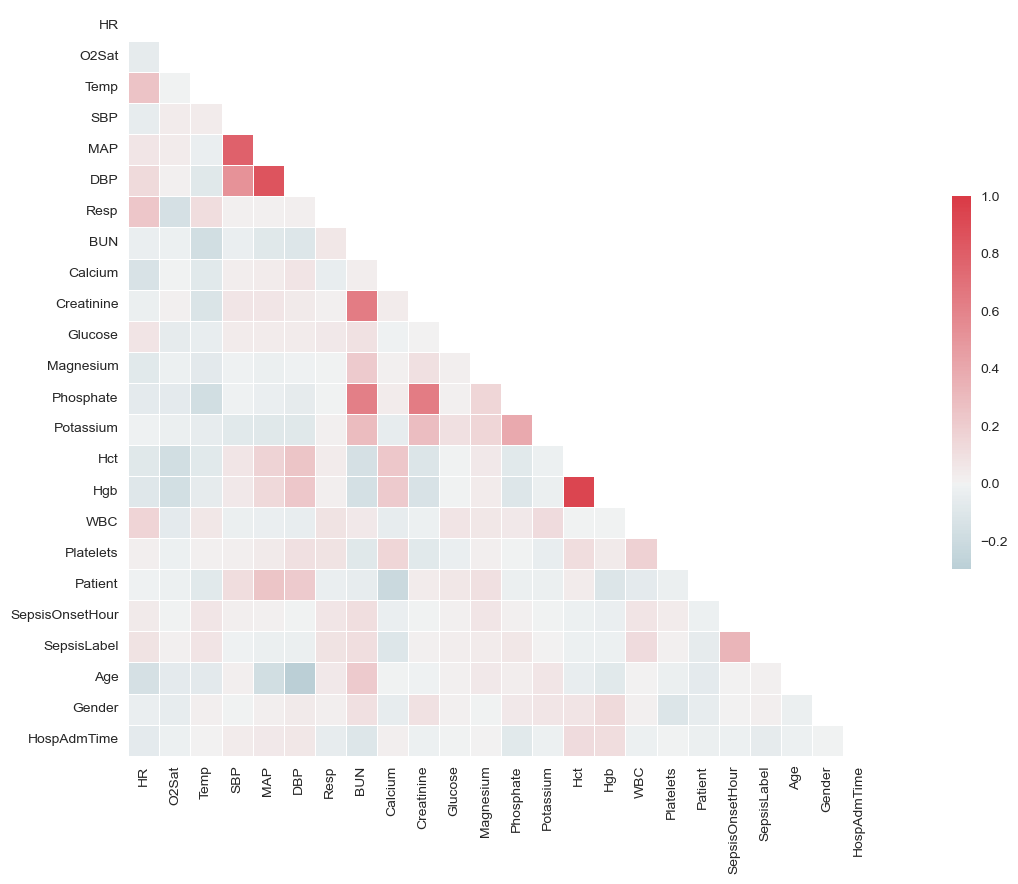

In [160]:
#look at feature correlations
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#make the heatmap plot
plt.figure(figsize=(16,9))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()
#plt.savefig('plots/heatmap.png', dpi=250)
plt.show()

# Resampling the highly imbalanced dataset

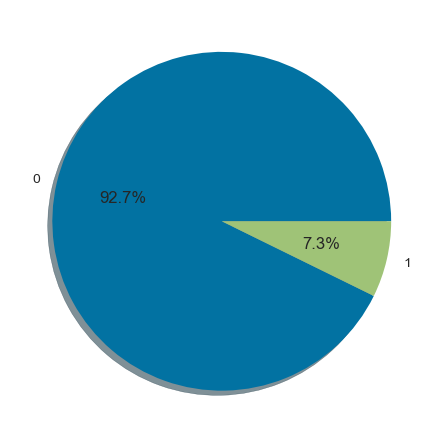

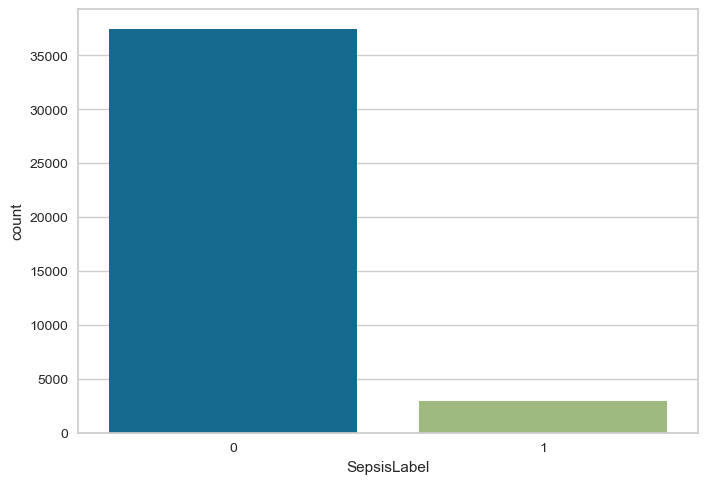

In [161]:
plt.pie(df['SepsisLabel'].value_counts(), labels=['0','1'], autopct='%1.1f%%', shadow=True)
plt.show()
sns.countplot(df['SepsisLabel'], label="Count")
plt.show()

In [162]:
df['SepsisLabel'].value_counts()

0    37404
1     2932
Name: SepsisLabel, dtype: int64

In [163]:
df_minority = df[df['SepsisLabel'] == 1]
df_majority = df[df['SepsisLabel'] == 0]

In [164]:
from sklearn.utils import resample

In [168]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=13000,    # to match majority class
                                 random_state=123) # reproducible results

In [169]:
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [170]:
df_upsampled.SepsisLabel.value_counts()

0    37404
1    13000
Name: SepsisLabel, dtype: int64

In [171]:
df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BUN', 'Calcium',
       'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 'Potassium', 'Hct',
       'Hgb', 'WBC', 'Platelets', 'Patient', 'SepsisOnsetHour', 'SepsisLabel',
       'Age', 'Gender', 'HospAdmTime'],
      dtype='object')

In [172]:
#X = df_upsampled[df_upsampled.drop(columns = ['Sepsis_predict'])].values
#Y = df_upsampled[df_upsampled['Sepsis_predict']].values
X = df_upsampled.drop(columns = ['SepsisLabel'])
Y = df_upsampled['SepsisLabel']

#get the train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

# EDA using DABL ( Data Analysis Baseline Library )

In [173]:
import dabl

In [174]:
default_clean = dabl.clean(df, verbose = 1)
df_datatypes = dabl.detect_types(default_clean)
default_clean = dabl.clean(df, verbose = 1)
print(df_datatypes['categorical'])
print(df_datatypes['continuous'])

Detected feature types:
continuous      21
dirty_float      0
low_card_int     1
categorical      2
date             0
free_string      0
useless          0
dtype: int64
Detected feature types:
continuous      21
dirty_float      0
low_card_int     1
categorical      2
date             0
free_string      0
useless          0
dtype: int64
HR                 False
O2Sat              False
Temp               False
SBP                False
MAP                False
DBP                False
Resp               False
BUN                False
Calcium            False
Creatinine         False
Glucose            False
Magnesium          False
Phosphate          False
Potassium          False
Hct                False
Hgb                False
WBC                False
Platelets          False
Patient            False
SepsisOnsetHour    False
SepsisLabel         True
Age                False
Gender              True
HospAdmTime        False
Name: categorical, dtype: bool
HR                  True
O2Sa

Target looks like classification
Showing only top 10 of 21 continuous features
Linear Discriminant Analysis training set score: 0.528


[[<Figure size 2000x400 with 10 Axes>,
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 800x550 with 1 Axes>],
 None]

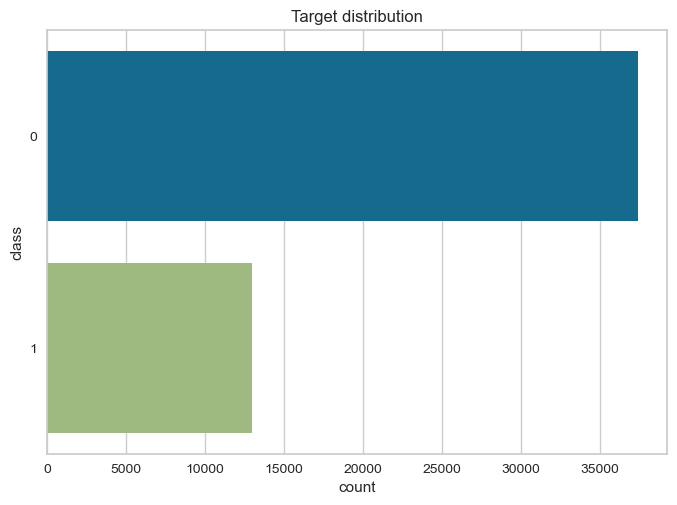

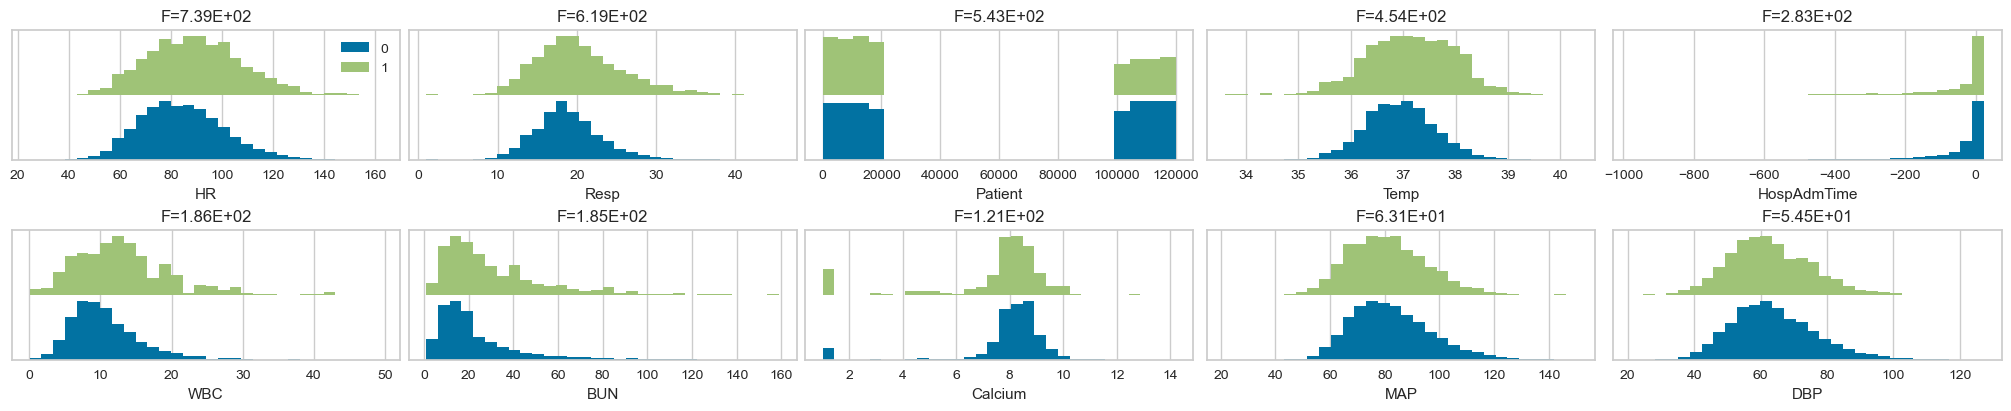

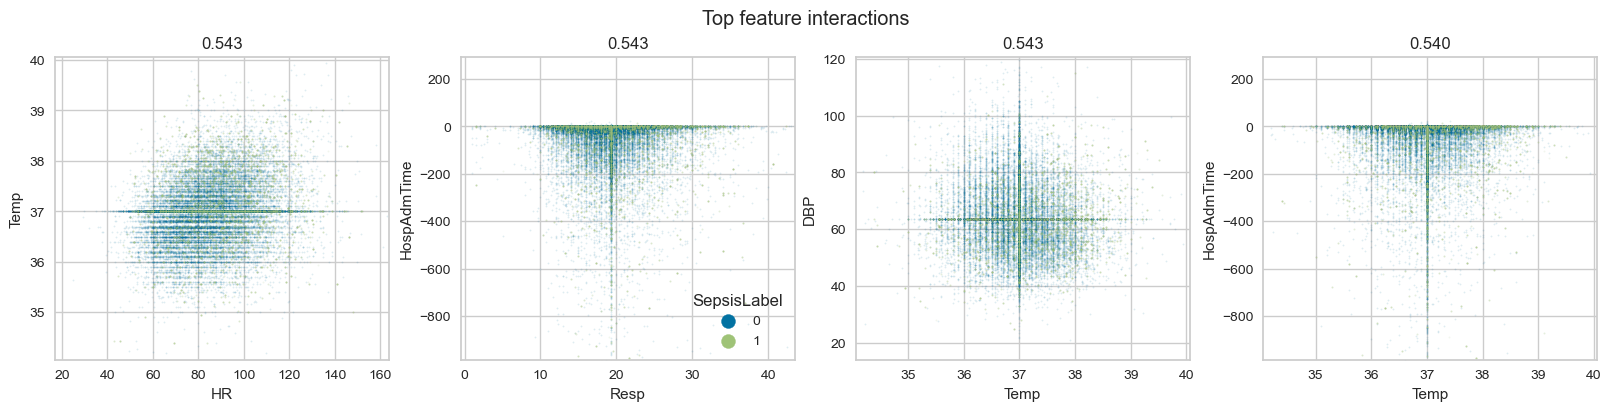

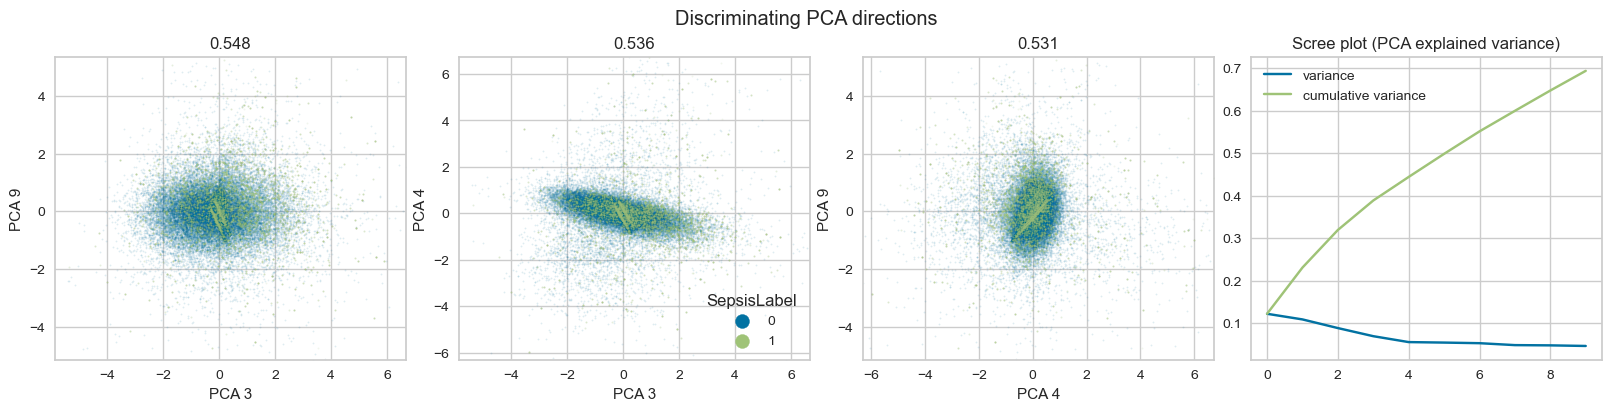

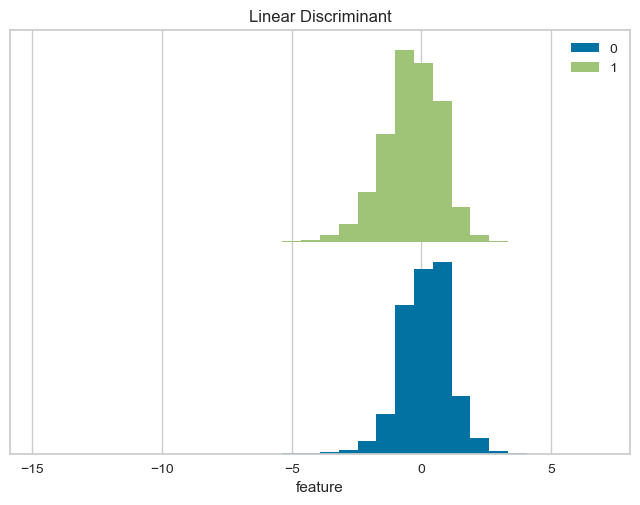

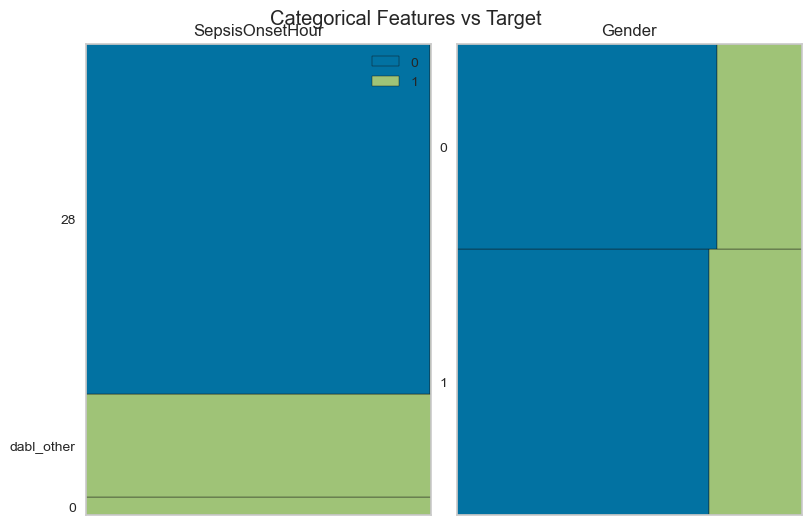

In [175]:
dabl.plot(df_upsampled, 'SepsisLabel') #only use the Target distributions AND top interaction variables charts

# Pipeline model

Read up how to interpret these plots and how to acutally relate it back to the project objectives.

In [ ]:
ec = dabl.SimpleClassifier().fit(df_upsampled.reset_index(), target_col = 'Sepsis_predict') #unable to run this

In [ ]:
dabl.explain(ec)

# Modeling using Pycaret

In [177]:
df_upsampled

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Hct,Hgb,WBC,Platelets,Patient,SepsisOnsetHour,SepsisLabel,Age,Gender,HospAdmTime
0,104.333333,89.666667,36.500000,156.666667,109.556667,NaN,27.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,28,0,83.14,0,-0.03
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,28,0,75.91,0,-98.60
2,78.500000,95.500000,38.060000,143.166667,83.166667,55.833333,23.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,28,0,45.82,0,-1195.71
3,109.666667,98.666667,36.720000,117.333333,66.670000,NaN,19.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,28,0,65.71,0,-8.77
4,88.000000,98.000000,37.280000,140.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5,28,0,28.09,1,-0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,90.333333,98.666667,38.220000,NaN,76.500000,NaN,24.666667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6051,22,1,67.70,1,-5.58
403,96.666667,99.666667,37.440000,132.333333,95.666667,73.333333,30.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4629,174,1,65.74,0,-93.58
1407,101.333333,99.333333,38.060000,143.666667,98.000000,73.333333,26.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,16060,39,1,48.39,1,-0.02
765,89.833333,99.666667,37.280000,79.916667,65.500000,55.500000,12.000000,NaN,NaN,NaN,...,28.9,NaN,NaN,NaN,9002,6,1,64.79,1,-8.65


In [178]:
s = setup(df_upsampled, target = 'SepsisLabel')

,Description,Value
0,Session id,1543
1,Target,SepsisLabel
2,Target type,Binary
3,Original data shape,"(133900, 24)"
4,Transformed data shape,"(133900, 24)"
5,Transformed train set shape,"(93730, 24)"
6,Transformed test set shape,"(40170, 24)"
7,Numeric features,23
8,Rows with missing values,95.1%
9,Preprocess,True


In [179]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8821,0.8330,0.9996,0.8413,0.9136,0.7324,0.7599,0.7730
xgboost,Extreme Gradient Boosting,0.8816,0.8227,0.9985,0.8412,0.9131,0.7312,0.7582,4.5120
gbc,Gradient Boosting Classifier,0.8809,0.8448,0.9971,0.8413,0.9126,0.7299,0.7563,6.7540
ada,Ada Boost Classifier,0.8747,0.8495,0.9844,0.8415,0.9074,0.7172,0.7386,1.8510
rf,Random Forest Classifier,0.8730,0.8011,0.9846,0.8395,0.9062,0.7131,0.7352,4.8530
et,Extra Trees Classifier,0.8624,0.7952,0.9666,0.8377,0.8975,0.6913,0.7079,5.3820
dt,Decision Tree Classifier,0.8622,0.7957,0.9668,0.8374,0.8975,0.6909,0.7076,0.8680
lda,Linear Discriminant Analysis,0.6496,0.6403,0.8494,0.6737,0.7514,0.1837,0.1985,0.2370
lr,Logistic Regression,0.6455,0.6357,0.8576,0.6681,0.7511,0.1673,0.1839,2.9270
ridge,Ridge Classifier,0.6451,0.0000,0.8567,0.6679,0.7506,0.1667,0.1831,0.1120


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [180]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

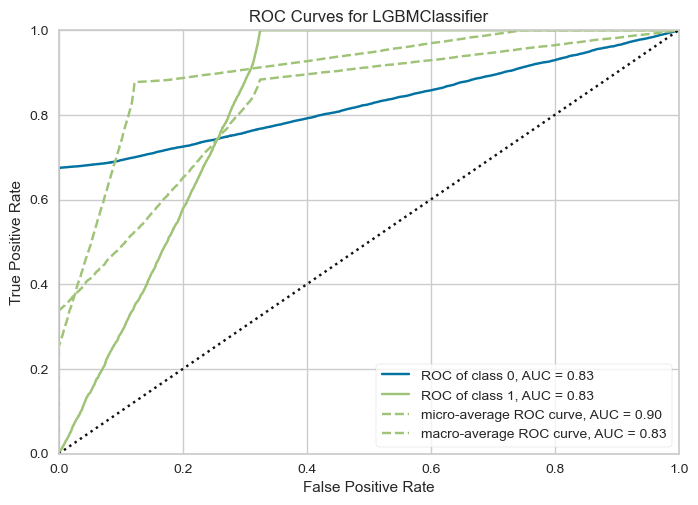

In [181]:
plot_model(best, plot = 'auc')

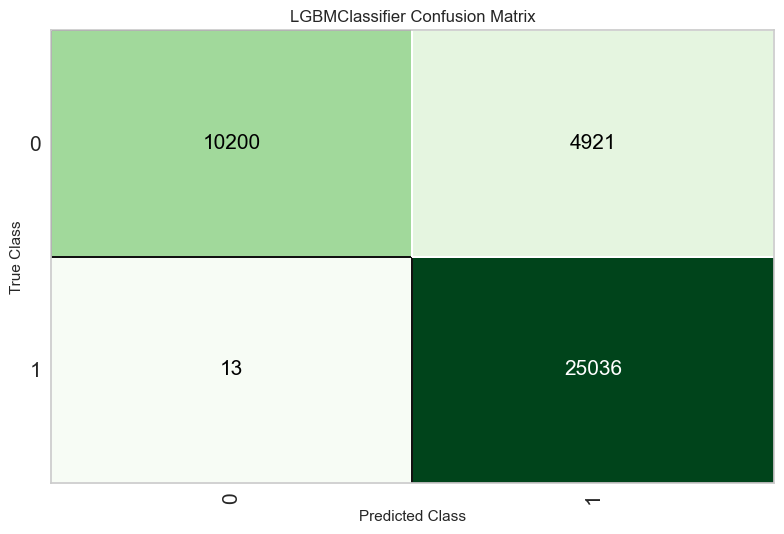

In [182]:
plot_model(best, plot = 'confusion_matrix')

In [183]:
predictions = predict_model(best, data=df, raw_score=True)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8729,0.9272,0.9983,0.4996,0.6659,0.5979,0.6526


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Platelets,Patient,SepsisOnsetHour,Age,Gender,HospAdmTime,SepsisLabel,prediction_label,prediction_score_0,prediction_score_1
0,116.333336,97.666664,37.720001,137.666672,105.000000,85.000000,27.000000,23.0,7.6,0.7,...,759.0,9,248,27.920000,1,-0.03,1,1,0.2042,0.7958
1,116.333336,97.666664,37.720001,137.666672,105.000000,85.000000,27.000000,23.0,7.6,0.7,...,759.0,9,248,27.920000,1,-0.03,0,1,0.2042,0.7958
2,104.333336,89.666664,36.500000,156.666672,109.556664,NaN,27.333334,NaN,NaN,NaN,...,NaN,1,28,83.139999,0,-0.03,1,1,0.1901,0.8099
3,104.333336,89.666664,36.500000,156.666672,109.556664,NaN,27.333334,NaN,NaN,NaN,...,NaN,1,28,83.139999,0,-0.03,0,1,0.1901,0.8099
4,98.666664,100.000000,37.560001,144.000000,85.000000,58.333332,NaN,NaN,NaN,NaN,...,NaN,11,24,65.790001,1,-0.02,1,1,0.1650,0.8350


In [184]:
save_model(best, 'my_best_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\gohch\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['HR', 'O2Sat', 'Temp', 'SBP',
                                              'MAP', 'DBP', 'Resp', 'BUN',
                                              'Calcium', 'Creatinine', 'Glucose',
                                              'Magnesium', 'Phosphate',
                                              'Potassium', 'Hct', 'Hgb', 'WBC',
                                              'Platelets', 'Patient',
                                              'SepsisOnsetHour', 'Age', 'Gender',
                                              'HospAdmTime']...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
             

# Multilayer Perceptron (MLP) model - comparison with best traditional ML models

In [ ]:
#Try MLP classifier - reference https://github.com/nevermind78/Early-Prediction-of-Sepsis-From-Clinical-Data/blob/main/MLP2.ipynb

In [ ]:
#Train test split
X = df_upsampled[df_upsampled.drop(columns = ['Sepsis_predict'])].values
Y = df_upsampled[df_upsampled['Sepsis_predict']].values

#get the train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neural_network import MLPClassifier

In [ ]:
clf=MLPClassifier(
    activation='tanh',
    solver='lbfgs',
    early_stopping=False,
    hidden_layer_sizes=(40,10,10,10,10, 2),
    random_state=1,
    batch_size='auto',
    max_iter=13000,
    learning_rate_init=1e-5,
    tol=1e-4,)

In [ ]:
clf.fit(X_train, Y_train)

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)
     

In [ ]:
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay

In [ ]:
predicted = loaded_model.predict(X_test)
print(predicted.shape)
print(Y_test.shape)
print(confusion_matrix(Y_test,predicted))

In [ ]:
cm=confusion_matrix(Y_test,predicted)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
def plot_ROC(y_test, y_score, n_classes=2):
    from sklearn.metrics import precision_score, classification_report,average_precision_score, accuracy_score, balanced_accuracy_score, precision_recall_curve, f1_score, auc, roc_curve
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr['positive'], tpr['positive'], _ = roc_curve(y_test, y_score)
    roc_auc['positive'] = auc(fpr['positive'], tpr['positive'])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    lw = 2
    plt.plot(fpr['positive'], tpr['positive'], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc['positive'])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
plot_ROC(Y_test,yhat_probas[:,1])

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

shap.initjs()
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)
# create a simple model
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}
model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)
# explain the model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
# visualize the impact of each features
shap.summary_plot(shap_values, X)